# Importing

## Importing modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
import time
import random
import math
from multiprocessing import Process, Queue

import keras
from keras.models import Sequential
from keras.layers import Activation, Dense
from keras.models import load_model
from keras.optimizers import SGD, adam, adagrad, rmsprop


Using TensorFlow backend.


## importing own code

In [2]:
from generateSpace import *
from plotLattice import *
from getTriangleLengths import *
from potentialEnergyPerTrio import *
from potentialEnergy import *
from potentialEnergyPerParticle import *
from numberOfCalculations import *
from makeRandomDatabase import *
from prepareDatabaseForMachineLearning import*

## Writing own code

In [3]:
def trainNetwork(network, trainingData, validationSplit, numberOfEpochs=50, batchSize=32, verboseSetting=-1):
    """
    hjhgj
    
    network is the Keras network to be trained.
    trainingData is the data to be trained with. It is a tupple with the index zero being the input data and index one being the target/output value.
    validationData is the data used to do validation.  It is a tupple with the index zero being the input data and index one being the target/output value.
    numberOfEpochs is the number of epochs the model will train for default is 50.
    batchSize is the size of the batches during gradiant decent defaul is 32.
    verboseSettings are the verbose settings default is -1 (which does nothing), 0 results in plots and above that normal rules apply.
    """
    
    #print(np.shape(trainingData[0]))
    #print(np.shape(trainingData[0][0]))
    #print(np.shape(trainingData[1]))
    
    #print(trainingData[0])
    
    fitDetails = network.fit(trainingData[0], trainingData[1], shuffle=True, batch_size=batchSize, validation_split=validationSplit, epochs=numberOfEpochs, verbose=max(0,verboseSetting))
    
    history = {'loss': fitDetails.history['loss'], 'val_loss': fitDetails.history['val_loss']}
    
    if verboseSetting>=0:
        
        maximumValue = max(max(history['loss']), max(history['val_loss']))
        minimumValue = min(min(history['loss']), min(history['val_loss'])) / 10#math.pow(math.floor(math.log(min(min(history['loss']), min(history['val_loss'])), 10)) - 1, 10)
        
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(16, 16))
        ax1.plot([i for i in range(1, numberOfEpochs + 1)], history['loss'], label='Training loss')
        ax1.plot([i for i in range(1, numberOfEpochs + 1)], history['val_loss'], label='Validation loss')
        ax1.legend()
        ax1.set_xlim(1, numberOfEpochs)
        ax1.set_ylim(0, maximumValue)
        ax1.set_xlabel('Epochs')
        ax1.set_ylabel('Loss')
        ax1.set_title('Loss (training and validation) vs the number of epochs.')
        
        ax2.plot(history['loss'], history['val_loss'])
        ax2.set_xlim(0, maximumValue)
        ax2.set_ylim(0, maximumValue)
        ax2.set_xlabel('Training loss')
        ax2.set_ylabel('Validation loss')
        ax2.set_title('Validation loss vs training loss.')
        
        ax3.plot([i for i in range(1, numberOfEpochs + 1)], history['loss'], label='Training loss')
        ax3.plot([i for i in range(1, numberOfEpochs + 1)], history['val_loss'], label='Validation loss')
        ax3.legend()
        ax3.set_xlim(1, numberOfEpochs)
        ax3.set_yscale('log')
        ax3.set_ylim(minimumValue, maximumValue)
        ax3.set_xlabel('Epochs')
        ax3.set_ylabel('Loss')
        ax3.set_title('Loss (training and validation) vs the number of epochs (logarithmic)')
        
        ax4.plot(history['loss'], history['val_loss'])
        ax4.set_xscale('log')
        ax4.set_xlim(minimumValue, maximumValue)
        ax4.set_yscale('log')
        ax4.set_ylim(minimumValue, maximumValue)
        ax4.set_xlabel('Training loss')
        ax4.set_ylabel('Validation loss')
        ax4.set_title('Validation loss vs training loss (logarithmic).')
        
        math.pow(math.log(min(min(history['loss']), min(history['val_loss'])), 10), 10)
        
        plt.show()
        history['figure'] = [fig, ax1, ax2, ax3, ax4]
    
    return history

In [4]:
def makePredictionPlot(model, dataFrame, amountOfPoints=1000):
    prediction = []
    realValue = []
    
    for i in range(min(len(dataFrame['potentialEnergy']), amountOfPoints)):
        index = dataFrame.index[i]
        prediction.append(model.predict([[dataFrame['eigenvalues'][index]]])[0][0])
        realValue.append(dataFrame['potentialEnergy'][index])
    
    fig, ((ax1)) = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))
    ax1.scatter(realValue, prediction, s=5)
    ax1.set_xlim(min(min(prediction), min(realValue)), max(max(prediction), max(realValue)))
    ax1.set_ylim(min(min(prediction), min(realValue)), max(max(prediction), max(realValue)))
    ax1.set_xlabel('Real energy')
    ax1.set_ylabel('Predicted energy')
    ax1.set_title('Predicted energy vs real energy.')
    
    plt.show()
    

In [5]:
def plotAndPredict(model, dataFrame, indexNumber):
    prediction = model.predict([[dataFrame['eigenvalues'][indexNumber]]])[0][0]
    realValue = dataFrame['potentialEnergy'][indexNumber]
    
    plotLatticeFromDataFrame(dataFrame, indexNumber)
    print('For index', indexNumber, 'Predicted', prediction, 'was', realValue)

In [6]:
def makeNetwork(inputSize, settings, learningRate, kernalInitializer='he_uniform', lossFunction='MAE'):#https://keras.io/api/losses/regression_losses/
    """
    jhgjhgj
    """
    model = Sequential()
    model.add(Dense(settings[0][1], input_dim=inputSize, use_bias=settings[0][3], kernel_initializer=kernalInitializer))#, kernel_initializer=kernalInitializer))
    model.add(Activation(settings[0][2]))
    
    for i in range(1, len(settings)):
        setting = settings[i]#0 is kind of layer, rest are settings.
        
        if setting[0]=='Dense':# 1 is amount of nodes, 2 is kind of activation, 3 is bias
            model.add(Dense(setting[1], use_bias=setting[3], kernel_initializer=kernalInitializer))
            model.add(Activation(setting[2]))
    
    opt = adam(lr=learningRate)
    model.compile(loss=lossFunction, optimizer=opt)#mse or mape
    
    return model

# Getting data

In [7]:
filename = 'databaseFilter_0.5_97_1-25_50k_AreaCirHighOPrepared'#'OLDcombinedDataR100M2M3M4Prepared'#'combinedDataPrepared'
inputSize = 16
orderOfMatrix = [-2, -3, -4, -5]# Make a list if you want to do the calculations yourself and make a other type of you want to import it


data = pd.read_json(filename + '.json', orient='columns')
data['particleCoordinates'] = data['particleCoordinates'].apply(np.array)
#data['eigenvalues'] = data['eigenvalues'].apply(np.transpose)
#data['eigenvalues'] = data['eigenvalues'].apply(list)

offset = 0#min(data['potentialEnergy'])
print(offset)

0


In [8]:
#data.head()

In [9]:
data.describe()

index   widthOfCell  numberOfSurroundingCells  potentialEnergy
count  49470.000000  49470.000000                   49470.0     4.947000e+04
mean   24734.500000     13.000000                       4.0     2.706328e+03
std    14280.903245      7.000071                       0.0     3.270756e+04
min        0.000000      1.000000                       4.0    -8.039692e+02
25%    12367.250000      7.000000                       4.0    -9.313451e-02
50%    24734.500000     13.000000                       4.0    -3.024844e-03
75%    37101.750000     19.000000                       4.0    -2.727727e-04
max    49469.000000     25.000000                       4.0     1.033311e+06

Offset is 0


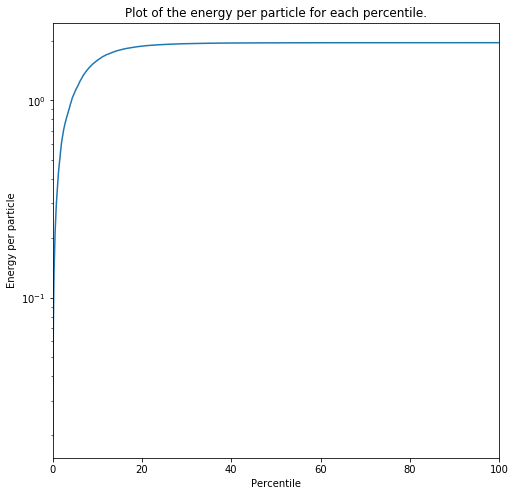

C:\Users\heisz\anaconda3\envs\BEPGPU\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


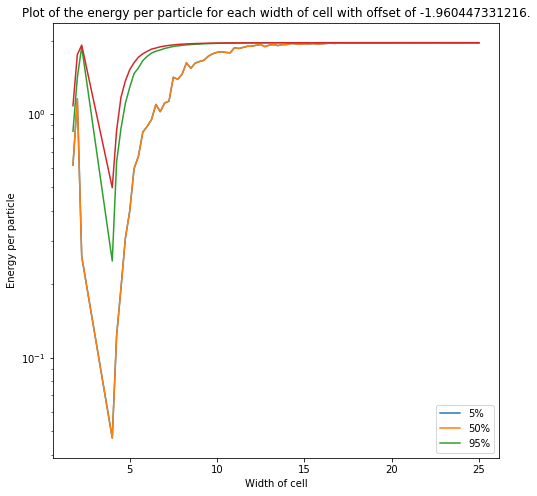

C:\Users\heisz\anaconda3\envs\BEPGPU\lib\site-packages\ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


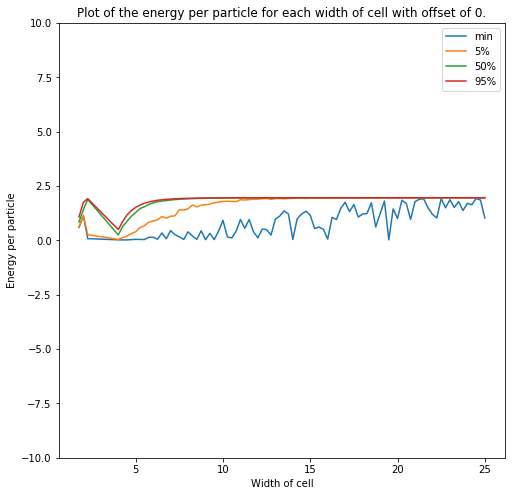

In [10]:
print('Offset is', offset)
data['potentialEnergy'] = data['potentialEnergy']-offset
qLow = data['potentialEnergy'].quantile(0.1)
qHi  = data['potentialEnergy'].quantile(0.90)
dataFiltered = data
dataFiltered = data[(data['potentialEnergy'] < qHi) & (data['potentialEnergy'] > qLow)]

x = dataFiltered['potentialEnergy']
fig, ax = plt.subplots(figsize=(8, 8))
sortedX = np.sort(x) - 1.01 * min(x)
ax.plot([100*i/len(x) for i in range(0, len(x))], sortedX)
ax.set_xlim(0, 100)
ax.set_yscale('log')
ax.set_title('Plot of the energy per particle for each percentile.')
ax.set_ylabel('Energy per particle')
ax.set_xlabel('Percentile')
plt.show()


#"""
tempData = dataFiltered
tempOfsett = 1.01 * min(tempData['potentialEnergy'])
tempData['potentialEnergy'] = tempData['potentialEnergy'] - tempOfsett
medianData = tempData.groupby('widthOfCell').describe(percentiles=[0.05, 0.5, 0.95])
fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(medianData.index, medianData['potentialEnergy']['5%'])
ax.plot(medianData.index, medianData['potentialEnergy']['5%'])
ax.plot(medianData.index, medianData['potentialEnergy']['50%'])
ax.plot(medianData.index, medianData['potentialEnergy']['95%'])
plt.legend(['5%', '50%', '95%'])
ax.set_yscale('log')
ax.set_title('Plot of the energy per particle for each width of cell with offset of ' + str(tempOfsett) + '.')
ax.set_ylabel('Energy per particle')
ax.set_xlabel('Width of cell')
plt.show()
#"""

#"""
tempData = dataFiltered
tempOfsett = 0#1.01 * min(tempData['potentialEnergy'])
tempData['potentialEnergy'] = tempData['potentialEnergy'] - tempOfsett
medianData = tempData.groupby('widthOfCell').describe(percentiles=[0.05, 0.5, 0.95])
fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(medianData.index, medianData['potentialEnergy']['min'])
ax.plot(medianData.index, medianData['potentialEnergy']['5%'])
ax.plot(medianData.index, medianData['potentialEnergy']['50%'])
ax.plot(medianData.index, medianData['potentialEnergy']['95%'])
plt.legend(['min', '5%', '50%', '95%'])
plt.ylim(-10**1, 10**1)
ax.set_title('Plot of the energy per particle for each width of cell with offset of ' + str(tempOfsett) + '.')
ax.set_ylabel('Energy per particle')
ax.set_xlabel('Width of cell')
plt.show()
#"""


data = dataFiltered

In [11]:
#data.head()

In [12]:
data.describe()

index   widthOfCell  numberOfSurroundingCells  potentialEnergy
count  39576.000000  39576.000000                   39576.0     39576.000000
mean   24910.841975     13.942471                       4.0         1.842031
std    14268.998719      5.697496                       0.0         0.311251
min      409.000000      1.750000                       4.0         0.019410
25%    12366.750000      9.000000                       4.0         1.919648
50%    24912.500000     14.000000                       4.0         1.957422
75%    37425.250000     18.750000                       4.0         1.960022
max    49469.000000     25.000000                       4.0         1.960375

In [13]:
trainingData = data.sample(frac=0.8)
validationData = data.drop(trainingData.index)

inputData = []
targetData = []
for i in trainingData.index:
    inputData.append(trainingData['eigenvalues'][i])#TODO remove sorted once fixed in data
    targetData.append(trainingData['potentialEnergy'][i])

trainingInput = [[inputData], [targetData]]

inputData = []
targetData = []
for i in validationData.index:
    inputData.append(validationData['eigenvalues'][i])#TODO remove sorted once fixed in data
    targetData.append(validationData['potentialEnergy'][i])

validationInput = [[inputData], [targetData]]

## Preparing testing

No handles with labels found to put in legend.


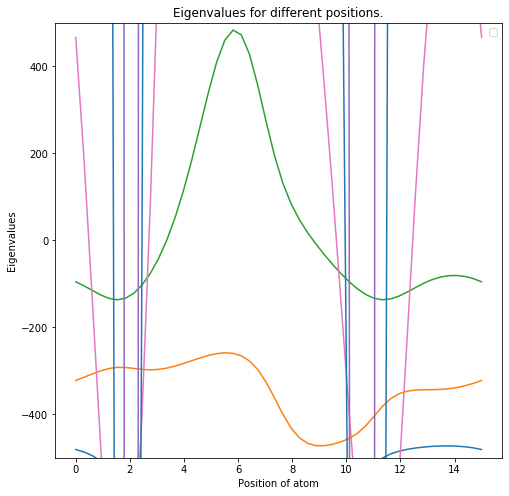

index  widthOfCell  numberOfSurroundingCells  potentialEnergy
count  50.00000         50.0                      50.0        50.000000
mean   24.50000         15.0                       4.0        -0.001066
std    14.57738          0.0                       0.0         0.000656
min     0.00000         15.0                       4.0        -0.002553
25%    12.25000         15.0                       4.0        -0.001389
50%    24.50000         15.0                       4.0        -0.000727
75%    36.75000         15.0                       4.0        -0.000567
max    49.00000         15.0                       4.0        -0.000534

In [14]:
#"""
widthOfCell = 15.0
numberOfSurroundingCells = 4
R0 = 100
x = np.linspace(0, 1, 50)

testData = {'particleCoordinates': [],'widthOfCell':[] , 'numberOfSurroundingCells': [], 'potentialEnergy':[]}# Initialy use a dictionary because it's easier to append to than a dataframe.
for i in x:
    particles = [np.array([0.3, 0.5]), np.array([0.9, 0.9]), np.array([0.6, 0.4]), np.array([0.5, i])]
    #particles = [np.array([0.3, 0.5]), np.array([0.3, 0.4]), np.array([0.6, 0.4]), np.array([0.5, i])]
    particles = [widthOfCell * coordinate for coordinate in particles]
    otherSpace = generateSpace(particles, numberOfSurroundingCells, widthOfCell)# Generate the other space.
    testData['particleCoordinates'].append(particles)
    testData['widthOfCell'].append(widthOfCell)
    testData['numberOfSurroundingCells'].append(numberOfSurroundingCells)
    testData['potentialEnergy'].append(potentialEnergy(otherSpace, particles, potentialEnergyPerTrio) - offset)# Calculate the potential energy and save it to the data dictonairy.

x = widthOfCell * x
testData = prepareDatabseForMachineLearning(pd.DataFrame(testData), orderOfMatrix, R0, giveUpdates = False)

#for i in range(len(x)):
#    print(testData['eigenvalues'][i])

fig, ax1 = plt.subplots(figsize=(8, 8))
ax1.plot(list(x), [testData['eigenvalues'][i] for i in range(len(testData['eigenvalues']))])
ax1.legend()
ax1.set_ylim(-500, 500)
ax1.set_xlabel('Position of atom')
ax1.set_ylabel('Eigenvalues')
ax1.set_title('Eigenvalues for different positions.')
plt.show()

testData.head()
testData.describe()
#"""

# Machine learning

In [15]:
models = []

## Model 0: Linear only

In [16]:
settings = [['Dense', 1, 'linear', False]]
learningRate = 1*10**-3

model = makeNetwork(inputSize, settings, learningRate, 'he_uniform')#eras.initializers.glorot_uniform(seed=None)
model.summary()

for i in range(len(model.layers)):
    print('Layer ' + str(i) + ': ', model.layers[i].get_weights())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1)                 16        
_________________________________________________________________
activation_1 (Activation)    (None, 1)                 0         
Total params: 16
Trainable params: 16
Non-trainable params: 0
_________________________________________________________________
Layer 0:  [array([[ 0.12089437],
       [ 0.5476211 ],
       [-0.33437055],
       [-0.36851332],
       [ 0.32535833],
       [-0.2817537 ],
       [-0.49073058],
       [ 0.5054378 ],
       [ 0.28508615],
       [-0.06062531],
       [ 0.20884871],
       [-0.5045595 ],
       [-0.06626576],
       [ 0.17839873],
       [ 0.3460757 ],
       [ 0.27777296]], dtype=float32)]
Layer 1:  []


Train on 22162 samples, validate on 9499 samples
Epoch 1/30
22162/22162 [==============================] - 2s 112us/step - loss: 56564702236.8024 - val_loss: 1392876742786.2373
Epoch 2/30
22162/22162 [==============================] - 2s 99us/step - loss: 6148234458.3902 - val_loss: 68052415079.6269
Epoch 3/30
22162/22162 [==============================] - 2s 91us/step - loss: 3304665313.2509 - val_loss: 27124699196.3689
Epoch 4/30
22162/22162 [==============================] - 2s 94us/step - loss: 2881900155.2916 - val_loss: 591927913974.6754
Epoch 5/30
22162/22162 [==============================] - 2s 91us/step - loss: 3946951827.2242 - val_loss: 336779352984.2922
Epoch 6/30
22162/22162 [==============================] - 2s 100us/step - loss: 3371419245.9947 - val_loss: 4969244688.4617
Epoch 7/30
22162/22162 [==============================] - 2s 91us/step - loss: 4278789473.6882 - val_loss: 16862940349.2060
Epoch 8/30
22162/22162 [==============================] - 2s 100us/step - los

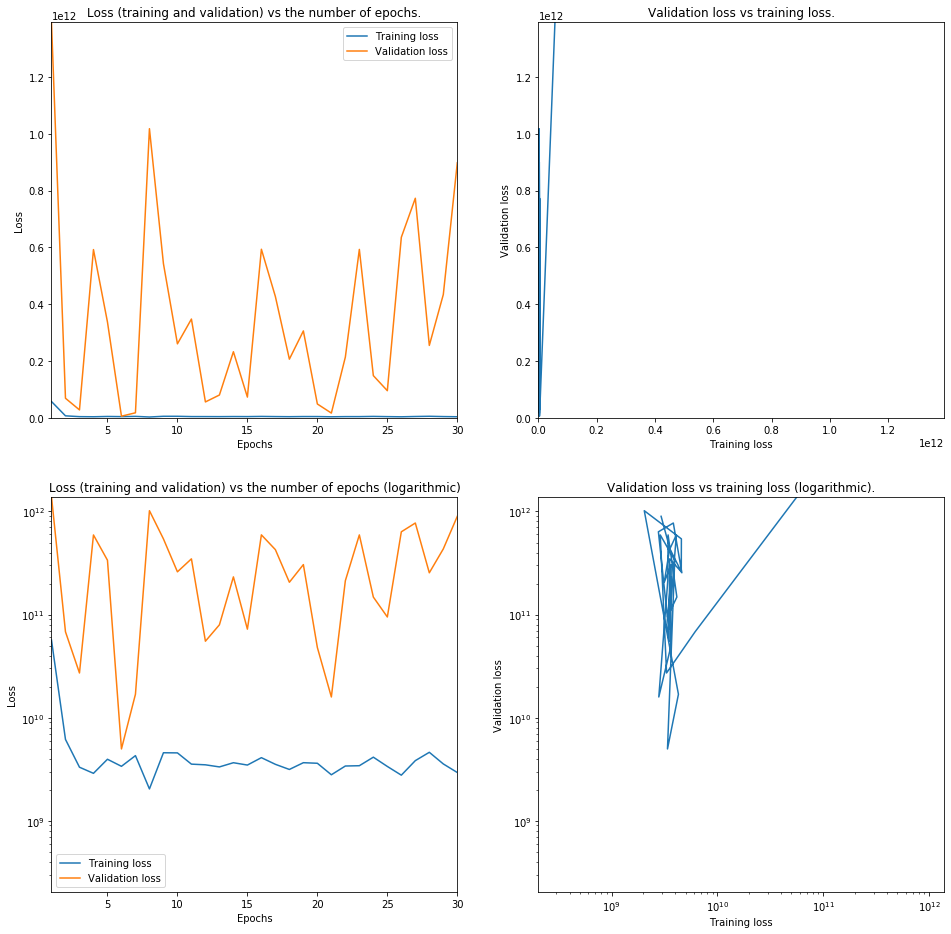


Layer 0:  [array([[ -5.454866  ],
       [-14.052275  ],
       [  7.617197  ],
       [  7.7851415 ],
       [ -0.23629707],
       [ -8.152491  ],
       [  2.8986921 ],
       [  1.0959941 ],
       [  0.34206733],
       [ -1.8454026 ],
       [  0.6709709 ],
       [ -0.56119096],
       [  0.09106246],
       [  0.13107577],
       [  0.09287686],
       [  0.12044846]], dtype=float32)]
Layer 1:  []


In [17]:
trainNetwork(model, trainingInput, 0.3, numberOfEpochs=30, batchSize=32, verboseSetting=1)
models.append([model, 'model0'])
print()

for i in range(len(model.layers)):
    print('Layer ' + str(i) + ': ', model.layers[i].get_weights())

7915/7915 [==============================] - 1s 65us/step
42191595214.32808


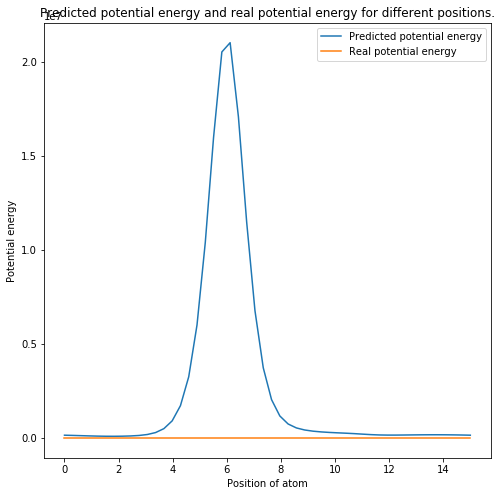

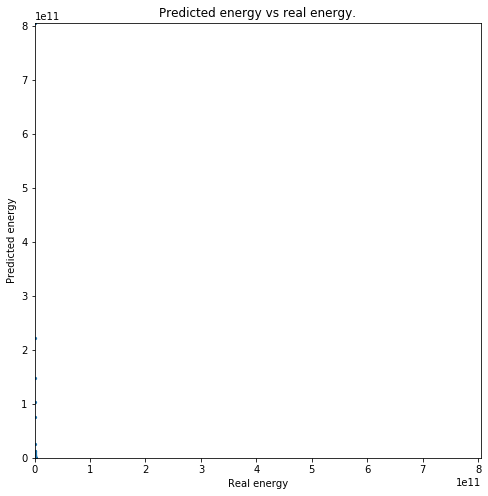

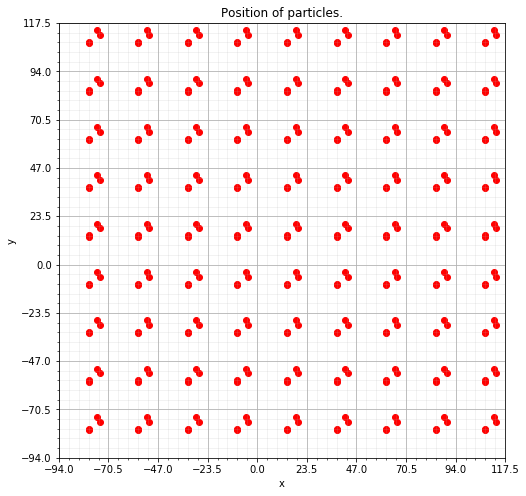

For index 1 Predicted 33045728.0 was 1.960273923016


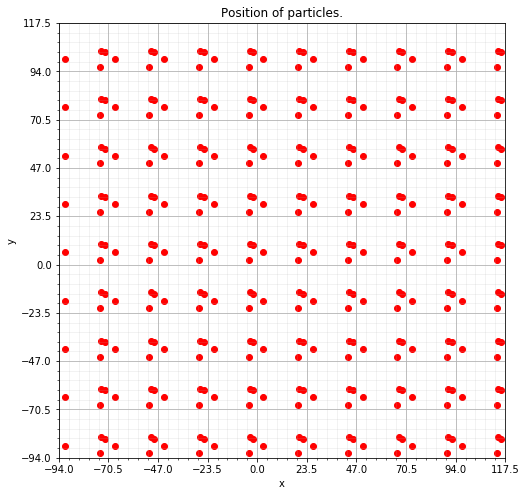

For index 2 Predicted -18681.25 was 1.960307948516


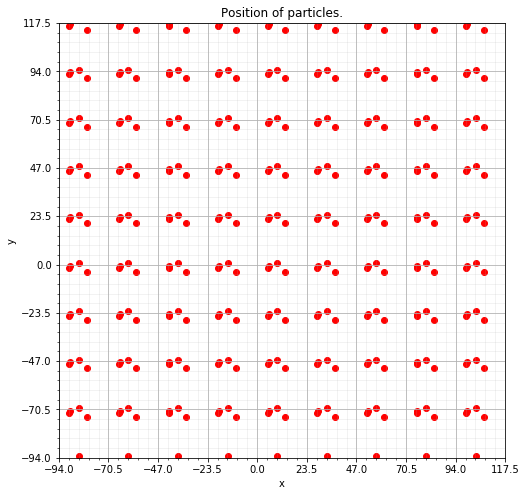

For index 8 Predicted 3492326.0 was 1.959772619816


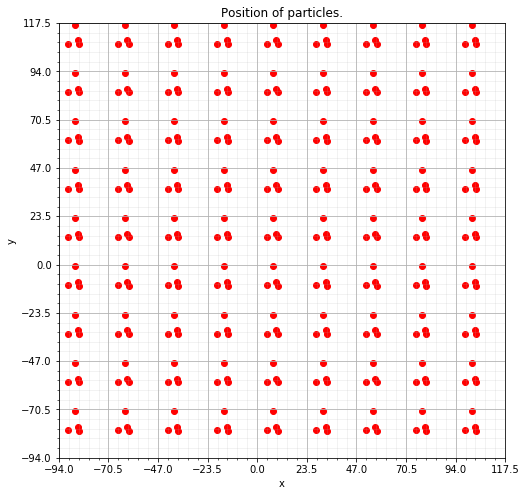

For index 23 Predicted -30232.5 was 1.959906160916


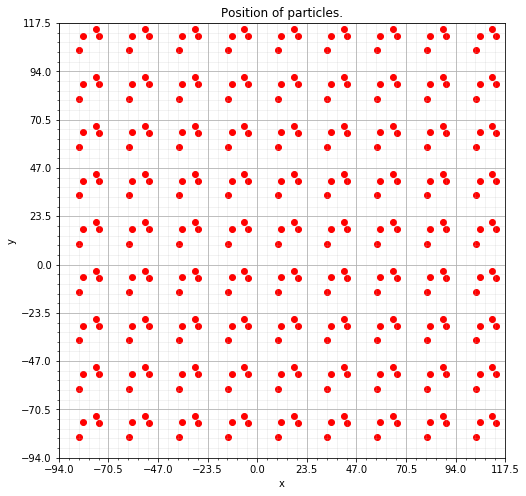

For index 27 Predicted 292.6914 was 1.960369115516


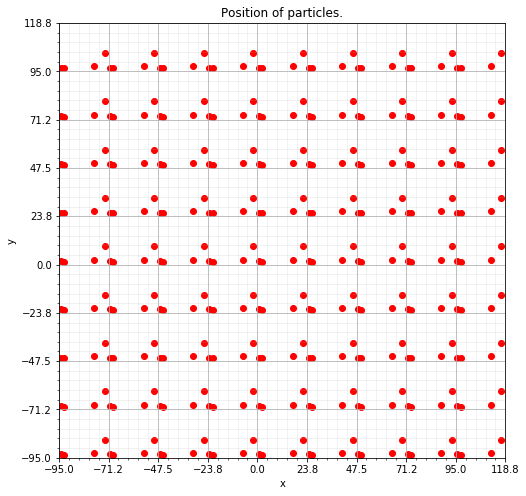

For index 33 Predicted 47448.5 was 1.9603575167160001


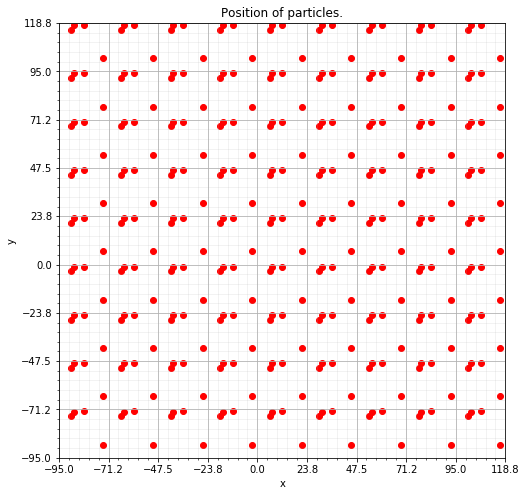

For index 55 Predicted -29309.812 was 1.960279331616


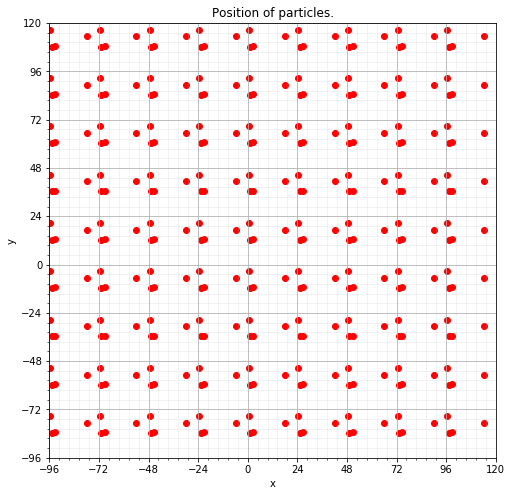

For index 80 Predicted 85125.0 was 1.960362907116


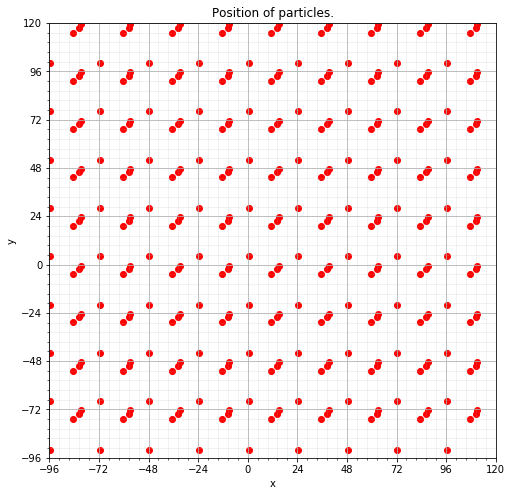

For index 91 Predicted -27381.875 was 1.960324234116


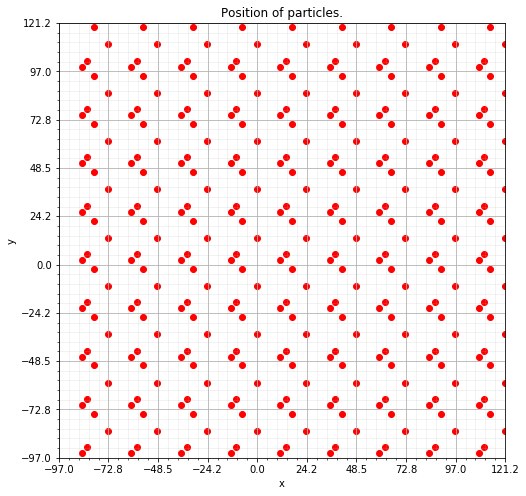

For index 108 Predicted -4139.1035 was 1.960354114916
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1)                 16        
_________________________________________________________________
activation_1 (Activation)    (None, 1)                 0         
Total params: 16
Trainable params: 16
Non-trainable params: 0
_________________________________________________________________
None
[array([[ -5.454866  ],
       [-14.052275  ],
       [  7.617197  ],
       [  7.7851415 ],
       [ -0.23629707],
       [ -8.152491  ],
       [  2.8986921 ],
       [  1.0959941 ],
       [  0.34206733],
       [ -1.8454026 ],
       [  0.6709709 ],
       [ -0.56119096],
       [  0.09106246],
       [  0.13107577],
       [  0.09287686],
       [  0.12044846]], dtype=float32)]
[]



In [18]:
#model = models[0][0]
print(model.evaluate(validationInput[0], validationInput[1]))

y = [[],[]]
for i in range(len(x)):
    y[0].append(model.predict([[testData['eigenvalues'][i]]])[0][0])
    y[1].append(testData['potentialEnergy'][i])


fig, ax1 = plt.subplots(figsize=(8, 8))
ax1.plot(list(x), y[0], label='Predicted potential energy')
ax1.plot(list(x), y[1], label='Real potential energy')
ax1.legend()
ax1.set_xlabel('Position of atom')
ax1.set_ylabel('Potential energy')
ax1.set_title('Predicted potential energy and real potential energy for different positions.')
#ax1.set_ylim(-0.75 * offset , 1.5 * max(y[1]))
plt.show()

makePredictionPlot(model, validationData)

for i in range(0,10):
    plotAndPredict(model, validationData, validationData.index[i])

#"""
print(model.summary())
for layer in model.layers:
    print(layer.get_weights())
#"""
print()

## Model 1: 1024 wide, 1 layer

In [19]:
settings = [['Dense', 1024, 'softplus', False], ['Dense', 1, 'linear', False]]
learningRate = 1*10**-3

model = makeNetwork(inputSize, settings, learningRate, 'he_uniform')#keras.initializers.glorot_uniform(seed=None)
model.summary()

for i in range(len(model.layers)):
    print('Layer ' + str(i) + ': ', model.layers[i].get_weights())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 1024)              16384     
_________________________________________________________________
activation_2 (Activation)    (None, 1024)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 1024      
_________________________________________________________________
activation_3 (Activation)    (None, 1)                 0         
Total params: 17,408
Trainable params: 17,408
Non-trainable params: 0
_________________________________________________________________
Layer 0:  [array([[ 0.5532586 , -0.07324666,  0.29489744, ..., -0.39252377,
         0.3734995 , -0.35787365],
       [-0.05670005, -0.31808633, -0.30490083, ..., -0.580944  ,
        -0.1531994 ,  0.09640867],
       [-0.3566957 ,  0.57151157,  0.

Train on 22162 samples, validate on 9499 samples
Epoch 1/100
22162/22162 [==============================] - 3s 149us/step - loss: 550808040144.1521 - val_loss: 26728364230341.1289
Epoch 2/100
22162/22162 [==============================] - 3s 125us/step - loss: 316686987195.6487 - val_loss: 32353811993809.2344
Epoch 3/100
22162/22162 [==============================] - 3s 136us/step - loss: 312778455452.9873 - val_loss: 87876038836668.7656
Epoch 4/100
22162/22162 [==============================] - 3s 151us/step - loss: 427690911166.4579 - val_loss: 49407196960516.5391
Epoch 5/100
22162/22162 [==============================] - 2s 103us/step - loss: 361717642539.1245 - val_loss: 7349875239886.2637
Epoch 6/100
22162/22162 [==============================] - 3s 115us/step - loss: 322001628623.2661 - val_loss: 3345867618677.2192
Epoch 7/100
22162/22162 [==============================] - 2s 108us/step - loss: 215515312522.7259 - val_loss: 4805957904988.5166
Epoch 8/100
22162/22162 [============

22162/22162 [==============================] - 3s 134us/step - loss: 126810940239.8969 - val_loss: 460585773133.7795
Epoch 64/100
22162/22162 [==============================] - 3s 117us/step - loss: 147621895166.8315 - val_loss: 1032384938760.0299
Epoch 65/100
22162/22162 [==============================] - 6s 279us/step - loss: 142956689034.6898 - val_loss: 6020871014330.9492
Epoch 66/100
22162/22162 [==============================] - 3s 154us/step - loss: 131272598981.4518 - val_loss: 15738676212902.3613
Epoch 67/100
22162/22162 [==============================] - 3s 149us/step - loss: 136676238861.6575 - val_loss: 59352780954.7544
Epoch 68/100
22162/22162 [==============================] - 3s 149us/step - loss: 146286924226.2891 - val_loss: 14529113554563.3027
Epoch 69/100
22162/22162 [==============================] - 4s 182us/step - loss: 122856337341.9276 - val_loss: 2778444365422.0737
Epoch 70/100
22162/22162 [==============================] - 4s 172us/step - loss: 122923996520.78

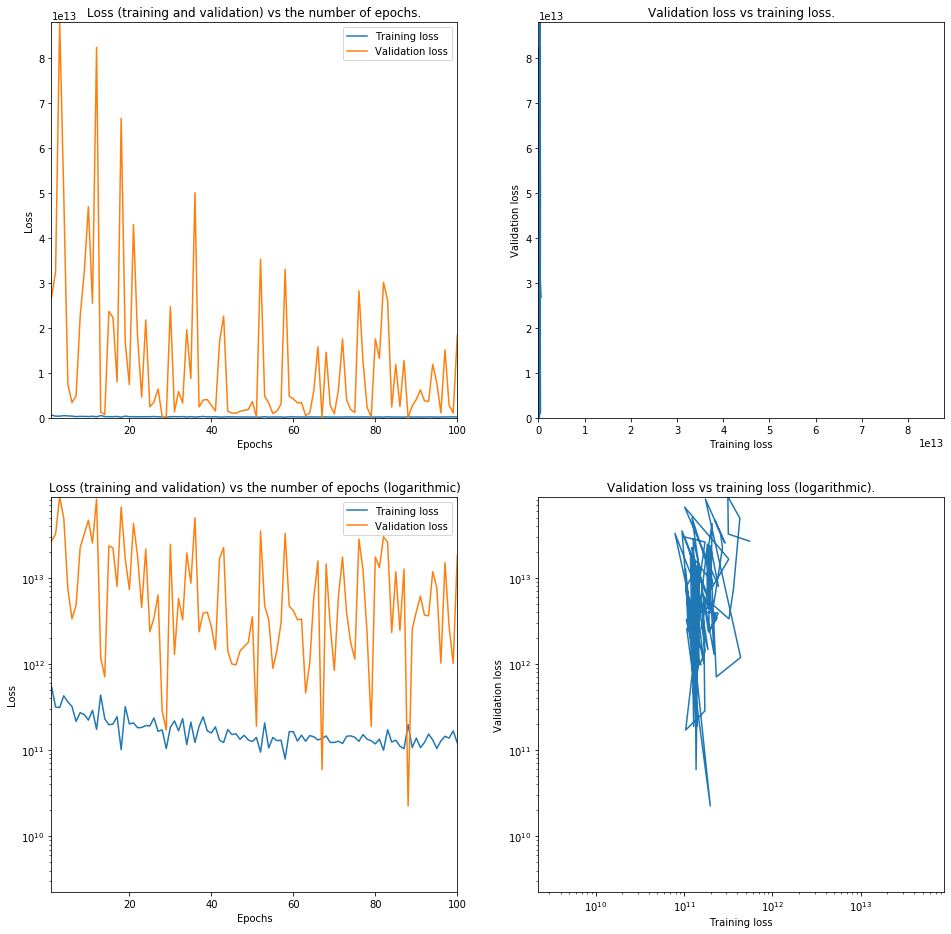

In [20]:
trainNetwork(model, trainingInput, 0.3, numberOfEpochs=100, batchSize=32, verboseSetting=1)
models.append([model, 'model1'])
print()

7915/7915 [==============================] - 0s 41us/step
867686914666.1567


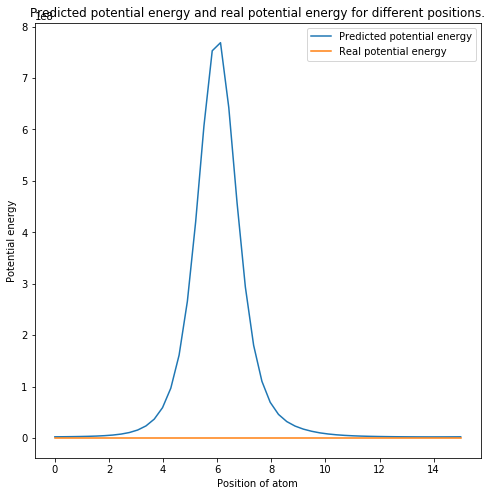

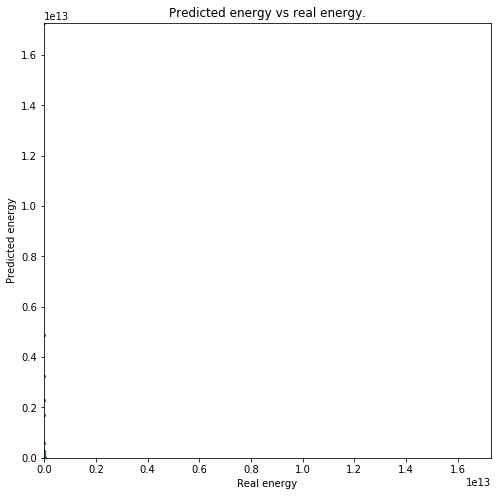

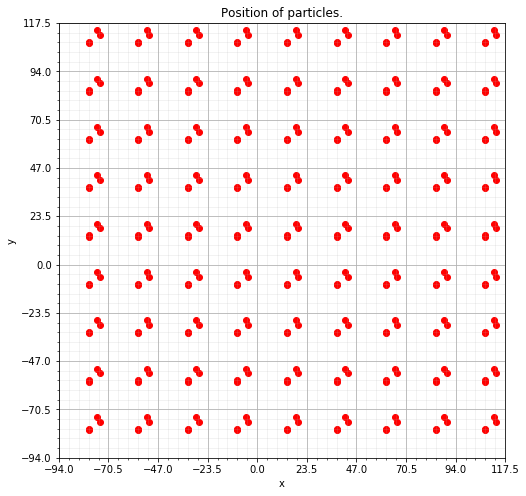

For index 1 Predicted 1133428200.0 was 1.960273923016


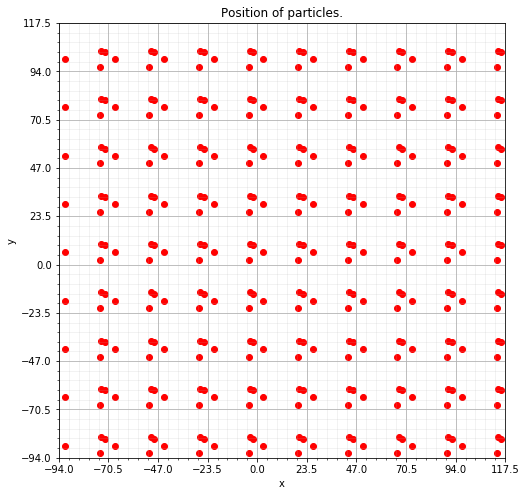

For index 2 Predicted 8071099.0 was 1.960307948516


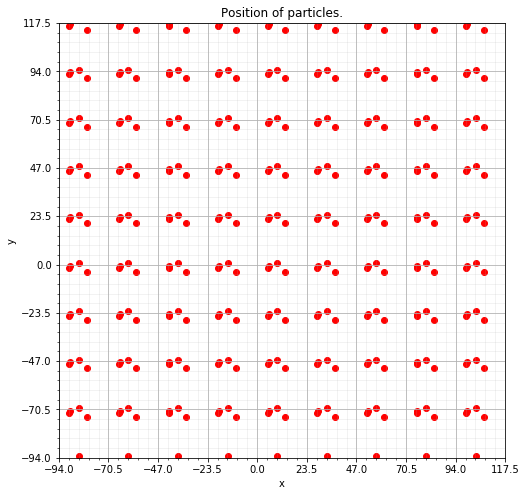

For index 8 Predicted 175555460.0 was 1.959772619816


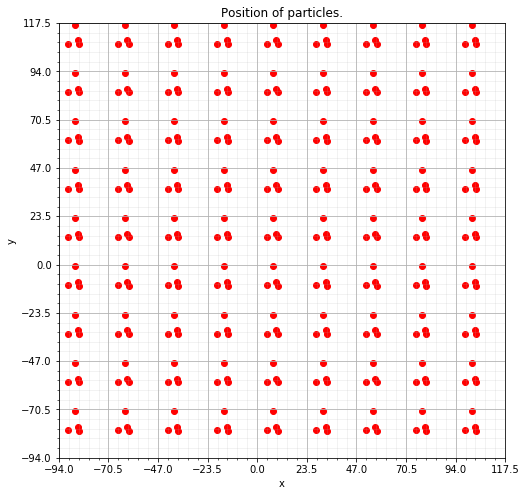

For index 23 Predicted 6282888.0 was 1.959906160916


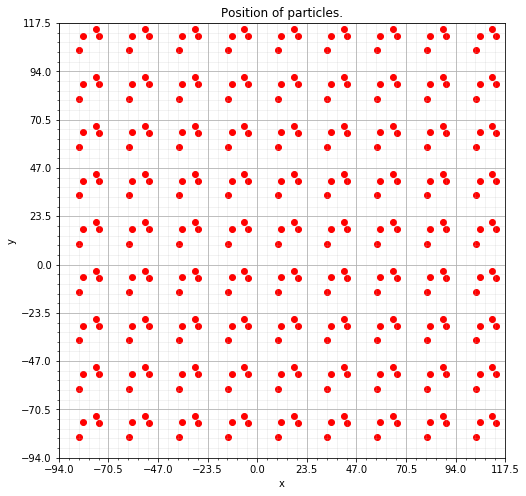

For index 27 Predicted 198935.89 was 1.960369115516


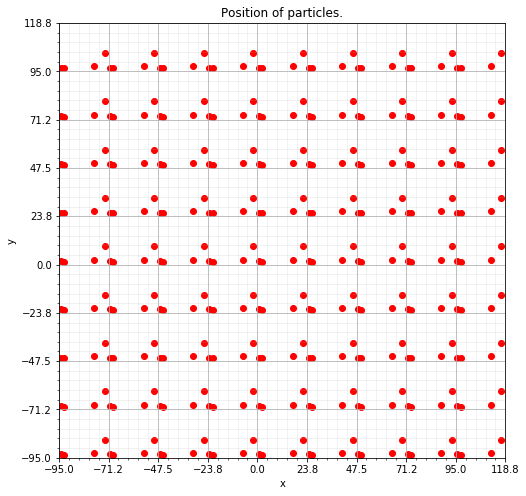

For index 33 Predicted 15510182.0 was 1.9603575167160001


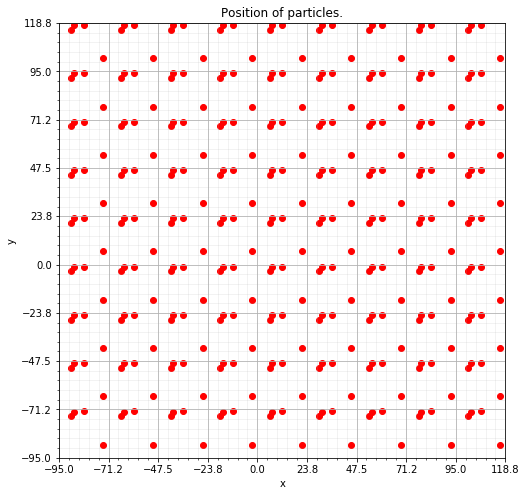

For index 55 Predicted 1726717.8 was 1.960279331616


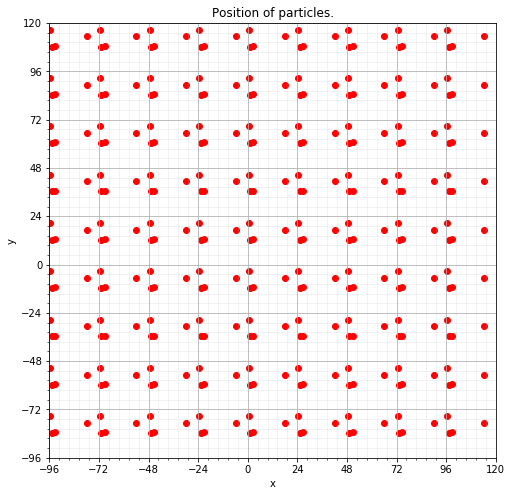

For index 80 Predicted 18411828.0 was 1.960362907116


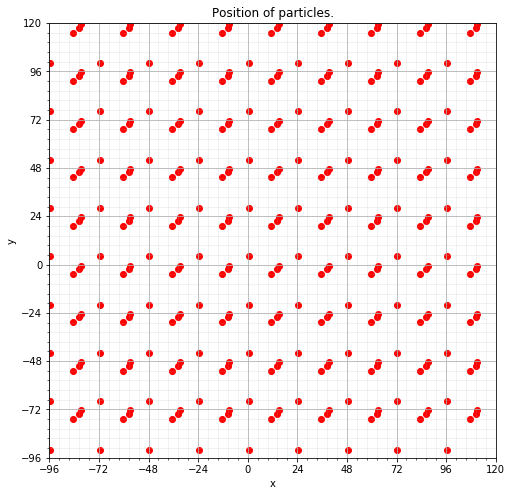

For index 91 Predicted 7154819.5 was 1.960324234116


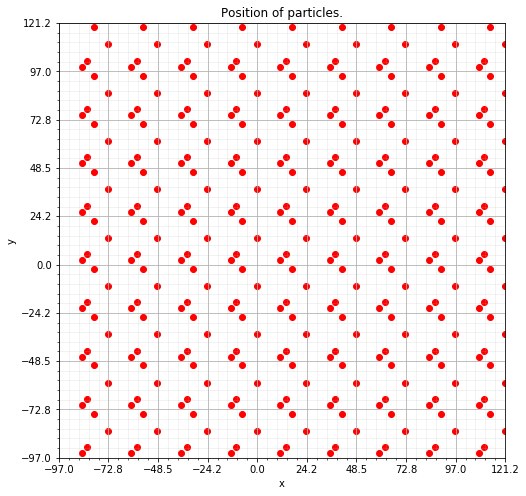

For index 108 Predicted 154459.39 was 1.960354114916
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 1024)              16384     
_________________________________________________________________
activation_2 (Activation)    (None, 1024)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 1024      
_________________________________________________________________
activation_3 (Activation)    (None, 1)                 0         
Total params: 17,408
Trainable params: 17,408
Non-trainable params: 0
_________________________________________________________________
None
[array([[ 1.8029171 ,  1.8297459 ,  1.8208978 , ..., -2.6973314 ,
         0.3734995 , -0.6677927 ],
       [ 4.420654  ,  2.318607  ,  1.5664979 , ..., -1.0868342 ,
        -0.1531994 ,  2.

In [21]:
#model = models[1][0]
print(model.evaluate(validationInput[0], validationInput[1]))

y = [[],[]]
for i in range(len(x)):
    y[0].append(model.predict([[testData['eigenvalues'][i]]])[0][0])
    y[1].append(testData['potentialEnergy'][i])


fig, ax1 = plt.subplots(figsize=(8, 8))
ax1.plot(list(x), y[0], label='Predicted potential energy')
ax1.plot(list(x), y[1], label='Real potential energy')
ax1.legend()
ax1.set_xlabel('Position of atom')
ax1.set_ylabel('Potential energy')
ax1.set_title('Predicted potential energy and real potential energy for different positions.')
#ax1.set_ylim(-0.75 * offset , 1.5 * max(y[1]))
plt.show()

makePredictionPlot(model, validationData)

for i in range(0,10):
    plotAndPredict(model, validationData, validationData.index[i])

#"""
print(model.summary())
for layer in model.layers:
    print(layer.get_weights())
#"""
print()


# ijgrhm;grgr
# iohjrthiokljnniklthttrh
# Esifgreiogrienrne
# nrgklngekmgre
# ijgrhm;grgr
# iohjrthiokljnniklthttrh
# Esifgreiogrienrne
# nrgklngekmgre
# ijgrhm;grgr
# iohjrthiokljnniklthttrh
# Esifgreiogrienrne
# nrgklngekmgre
# ijgrhm;grgr
# iohjrthiokljnniklthttrh
# Esifgreiogrienrne
# nrgklngekmgre
## Model 2: 2048 wide, 1 layer

In [22]:
settings = [['Dense', 2048, 'softplus', False], ['Dense', 1, 'linear', False]]
learningRate = 5*10**-4

model = makeNetwork(inputSize, settings, learningRate, 'he_uniform')
model.summary()

for i in range(len(model.layers)):
    print('Layer ' + str(i) + ': ', model.layers[i].get_weights())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 2048)              32768     
_________________________________________________________________
activation_4 (Activation)    (None, 2048)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 2048      
_________________________________________________________________
activation_5 (Activation)    (None, 1)                 0         
Total params: 34,816
Trainable params: 34,816
Non-trainable params: 0
_________________________________________________________________
Layer 0:  [array([[-0.28651625,  0.37420046, -0.52364093, ...,  0.53823584,
         0.2610426 , -0.05621493],
       [-0.5129083 ,  0.2866335 , -0.3887168 , ..., -0.59221905,
         0.3655479 , -0.1012181 ],
       [ 0.35775292,  0.28731227, -0.

Train on 22162 samples, validate on 9499 samples
Epoch 1/30
22162/22162 [==============================] - 2s 103us/step - loss: 131664253716.4991 - val_loss: 5367163973709.6836
Epoch 2/30
22162/22162 [==============================] - 3s 114us/step - loss: 215879550189.7311 - val_loss: 127212003926053.2812
Epoch 3/30
22162/22162 [==============================] - 2s 108us/step - loss: 655707919896.8943 - val_loss: 8809602893132.0840
Epoch 4/30
22162/22162 [==============================] - 3s 122us/step - loss: 328390735627.0333 - val_loss: 44133351224102.1719
Epoch 5/30
22162/22162 [==============================] - 2s 101us/step - loss: 342818648772.7241 - val_loss: 17953335501404.6484
Epoch 6/30
22162/22162 [==============================] - 2s 105us/step - loss: 390294401515.7563 - val_loss: 3939511737414.9800
Epoch 7/30
22162/22162 [==============================] - 2s 101us/step - loss: 408232802860.8912 - val_loss: 15084447699730.6738
Epoch 8/30
22162/22162 [===================

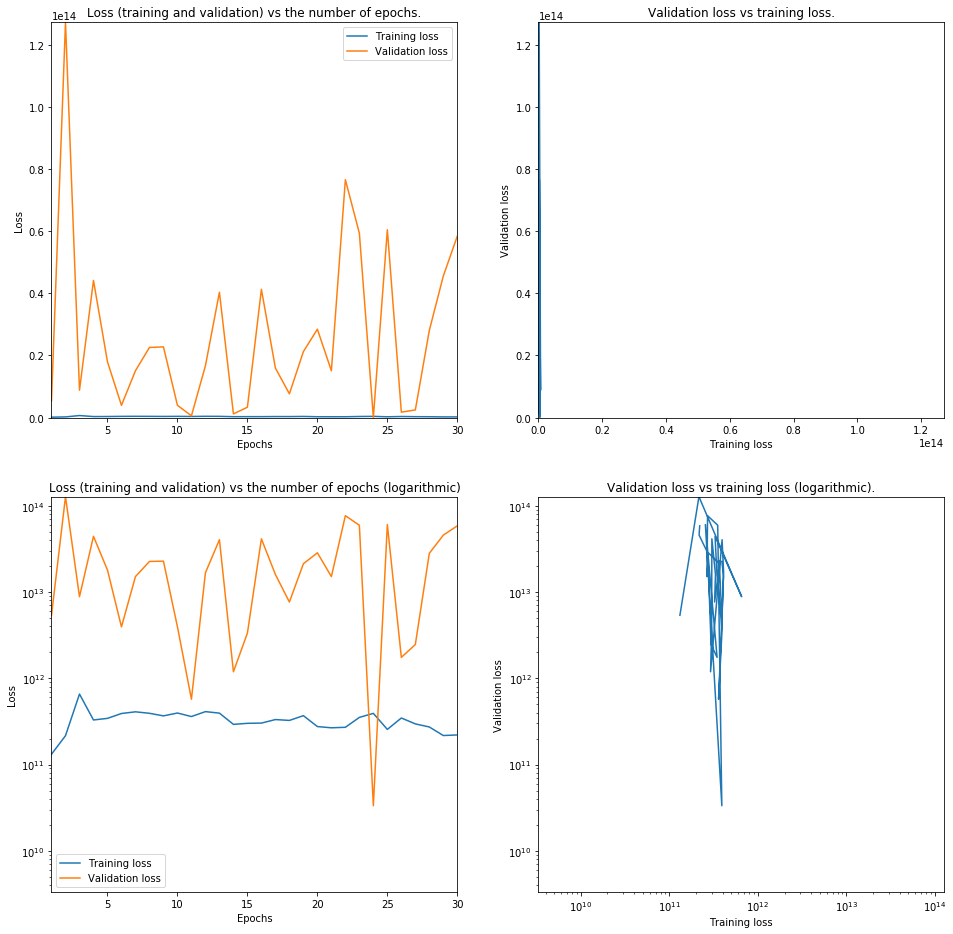

In [23]:
trainNetwork(model, trainingInput, 0.3, numberOfEpochs=30, batchSize=32, verboseSetting=1)
models.append([model, 'model2'])
print()

7915/7915 [==============================] - 0s 38us/step
2773881589133.1455


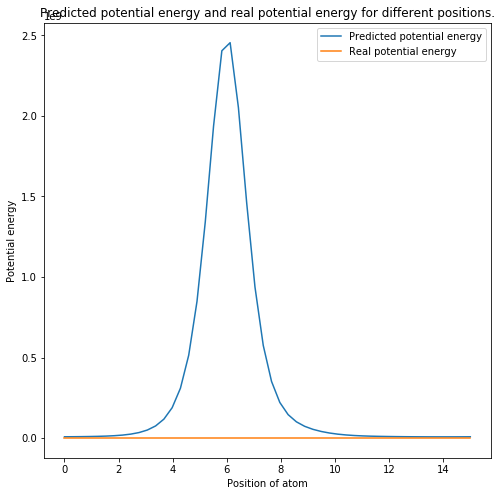

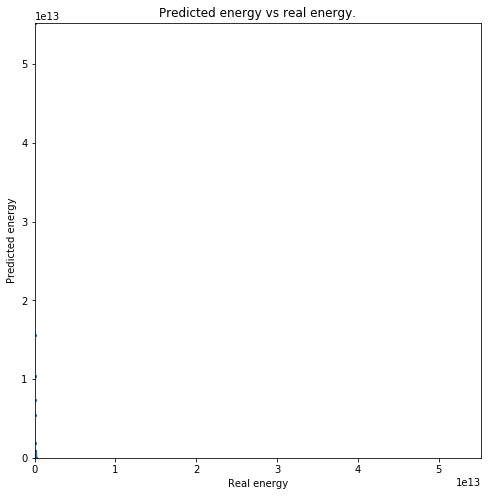

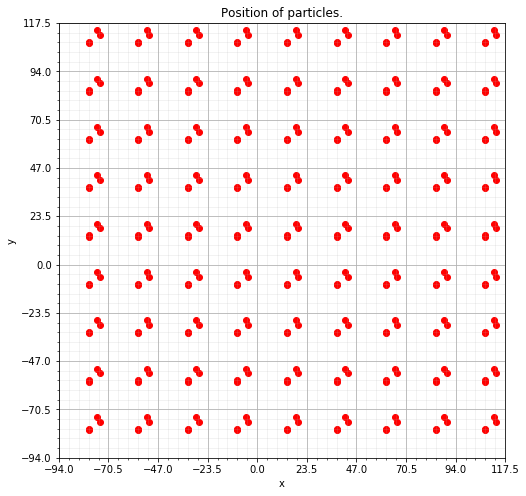

For index 1 Predicted 3622170000.0 was 1.960273923016


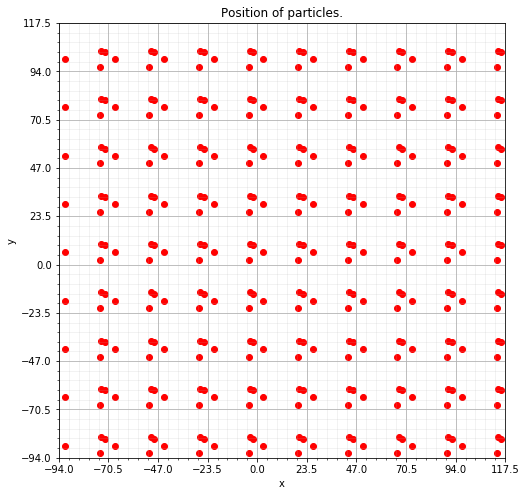

For index 2 Predicted 25712236.0 was 1.960307948516


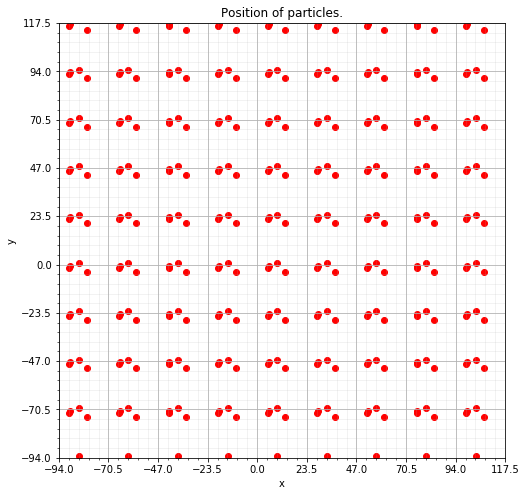

For index 8 Predicted 560347970.0 was 1.959772619816


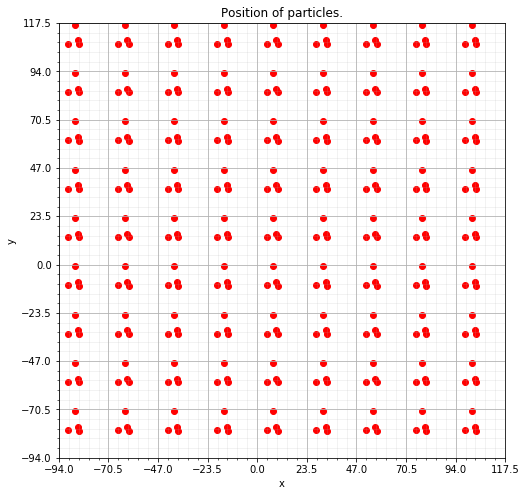

For index 23 Predicted 20008230.0 was 1.959906160916


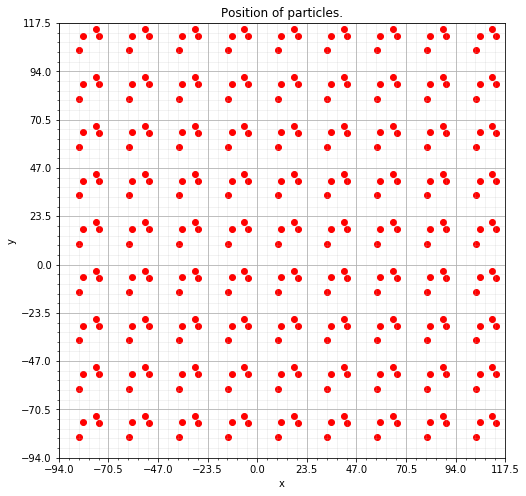

For index 27 Predicted 680119.4 was 1.960369115516


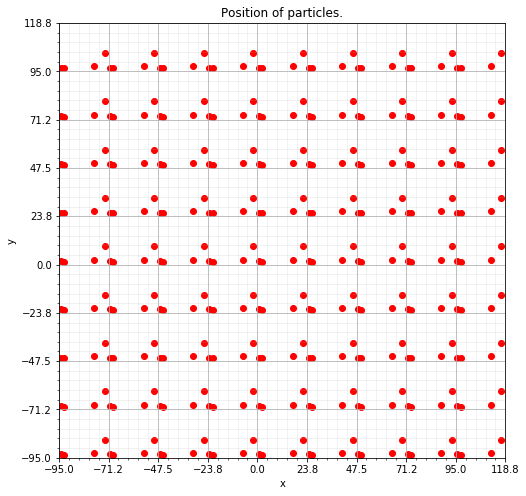

For index 33 Predicted 49403708.0 was 1.9603575167160001


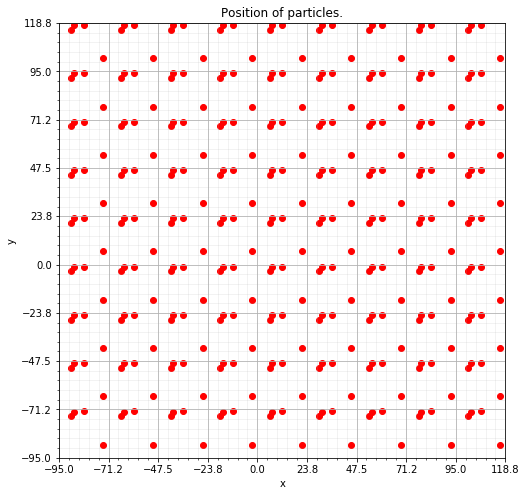

For index 55 Predicted 5502805.5 was 1.960279331616


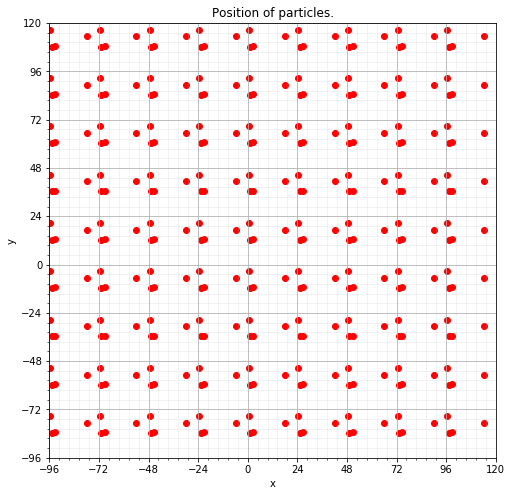

For index 80 Predicted 58664820.0 was 1.960362907116


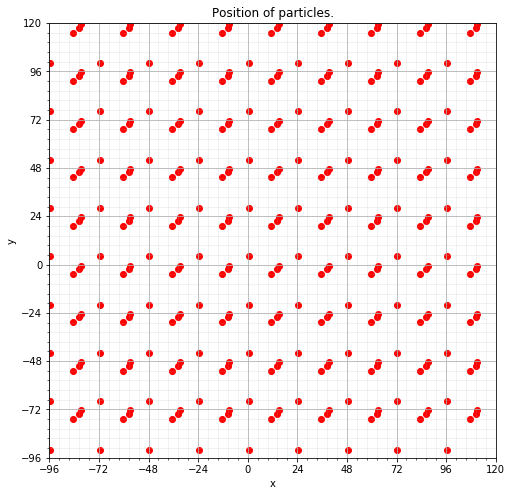

For index 91 Predicted 22779984.0 was 1.960324234116


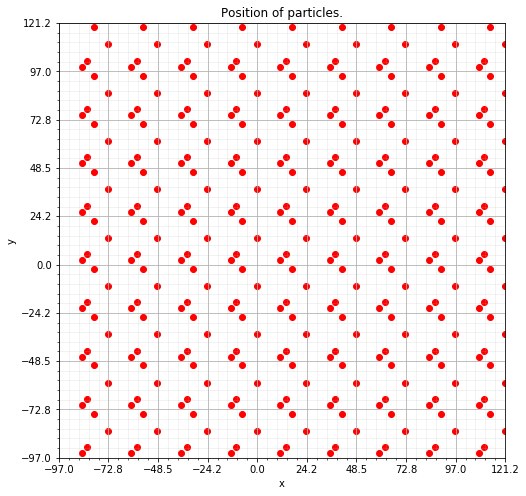

For index 108 Predicted 506184.8 was 1.960354114916



In [24]:
#model = models[2][0]
print(model.evaluate(validationInput[0], validationInput[1]))

y = [[],[]]
for i in range(len(x)):
    y[0].append(model.predict([[testData['eigenvalues'][i]]])[0][0])
    y[1].append(testData['potentialEnergy'][i])


fig, ax1 = plt.subplots(figsize=(8, 8))
ax1.plot(list(x), y[0], label='Predicted potential energy')
ax1.plot(list(x), y[1], label='Real potential energy')
ax1.legend()
ax1.set_xlabel('Position of atom')
ax1.set_ylabel('Potential energy')
ax1.set_title('Predicted potential energy and real potential energy for different positions.')
#ax1.set_ylim(-0.75 * offset , 1.5 * max(y[1]))
plt.show()

makePredictionPlot(model, validationData)

for i in range(0,10):
    plotAndPredict(model, validationData, validationData.index[i])

"""
print(model.summary())
for layer in model.layers:
    print(layer.get_weights())
#"""
print()

## Model 3: 4096 wide, 1 layer

In [25]:
settings = [['Dense', 4096, 'softplus', False], ['Dense', 1, 'linear', False]]
learningRate = 5*10**-4

model = makeNetwork(inputSize, settings, learningRate)
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 4096)              65536     
_________________________________________________________________
activation_6 (Activation)    (None, 4096)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 4096      
_________________________________________________________________
activation_7 (Activation)    (None, 1)                 0         
Total params: 69,632
Trainable params: 69,632
Non-trainable params: 0
_________________________________________________________________


Train on 22162 samples, validate on 9499 samples
Epoch 1/30
22162/22162 [==============================] - 3s 118us/step - loss: 640893932253.7676 - val_loss: 101099841334.2339
Epoch 2/30
22162/22162 [==============================] - 3s 115us/step - loss: 408952300596.4255 - val_loss: 227949673826256.9062
Epoch 3/30
22162/22162 [==============================] - 2s 107us/step - loss: 1077344060673.7004 - val_loss: 7848705155353.3555
Epoch 4/30
22162/22162 [==============================] - 2s 99us/step - loss: 502453108348.3469 - val_loss: 130992668685567.1719
Epoch 5/30
22162/22162 [==============================] - 2s 105us/step - loss: 722979794179.6510 - val_loss: 143628863421593.4688
Epoch 6/30
22162/22162 [==============================] - 2s 101us/step - loss: 837289542920.1053 - val_loss: 5164399417199.1006
Epoch 7/30
22162/22162 [==============================] - 2s 99us/step - loss: 623762949364.4323 - val_loss: 2434755724543.3657
Epoch 8/30
22162/22162 [====================

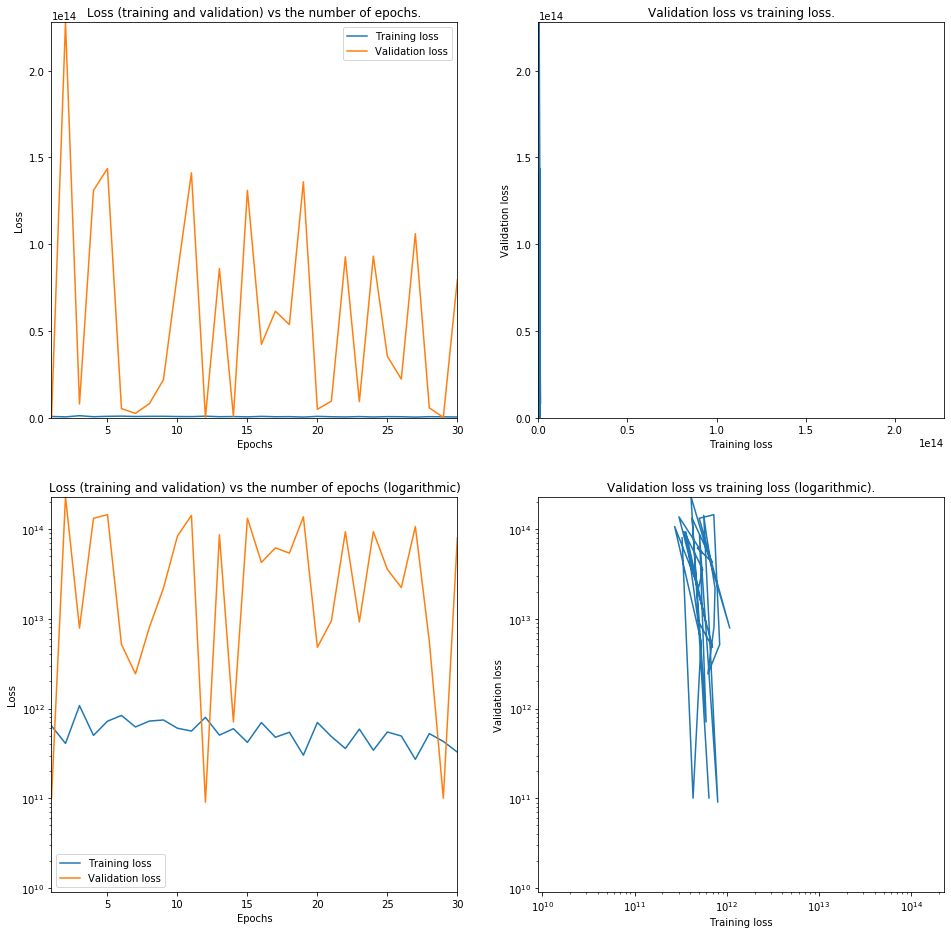

In [26]:
trainNetwork(model, trainingInput, 0.3, numberOfEpochs=30, batchSize=32, verboseSetting=1)
models.append([model, 'model3'])
print()

7915/7915 [==============================] - 0s 38us/step
3768372471916.791


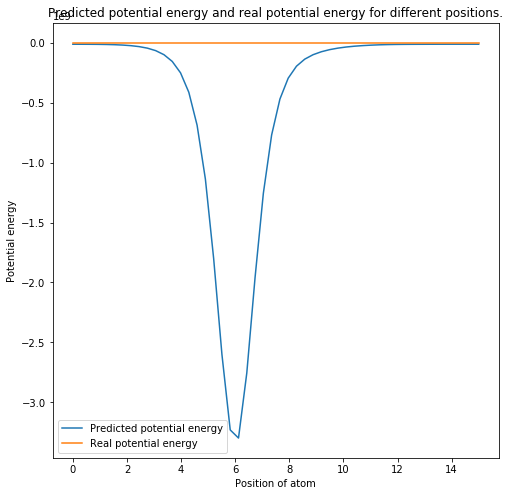

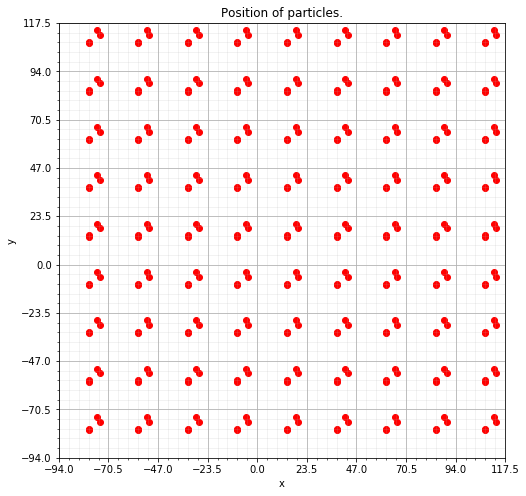

For index 1 Predicted -4875920000.0 was 1.960273923016


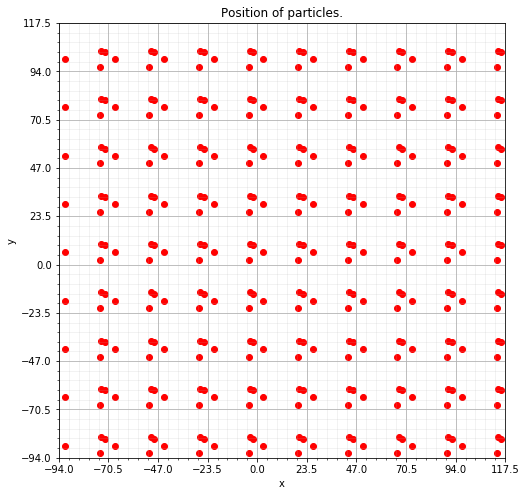

For index 2 Predicted -33827544.0 was 1.960307948516


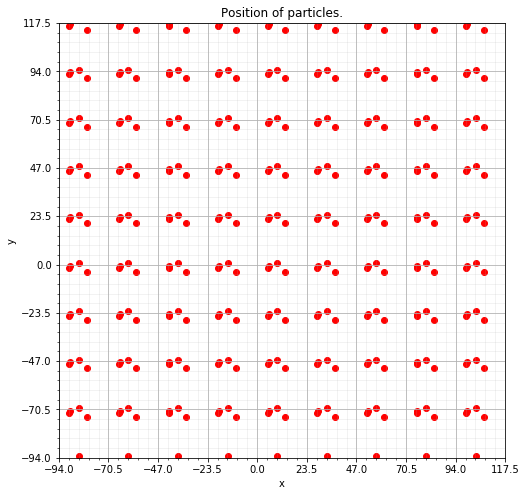

For index 8 Predicted -749268600.0 was 1.959772619816


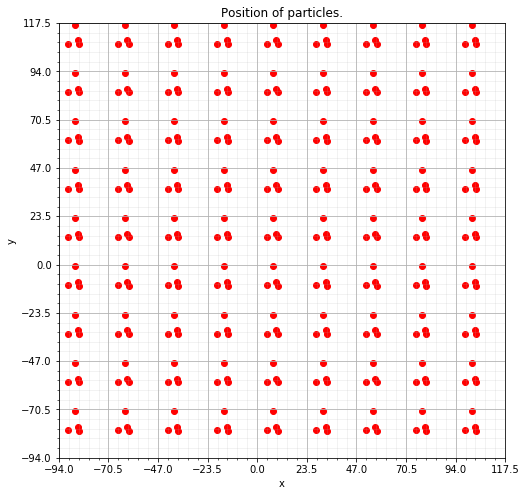

For index 23 Predicted -26258890.0 was 1.959906160916


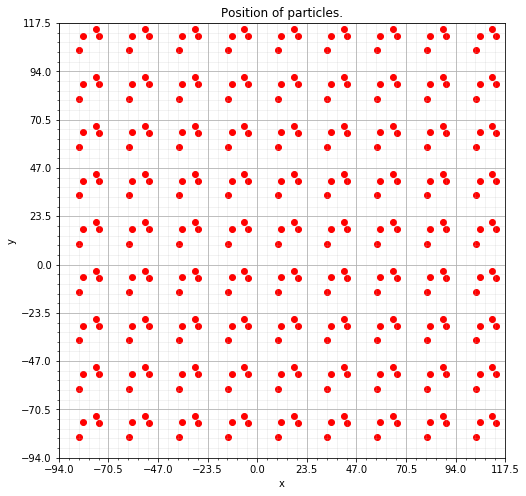

For index 27 Predicted -897395.2 was 1.960369115516


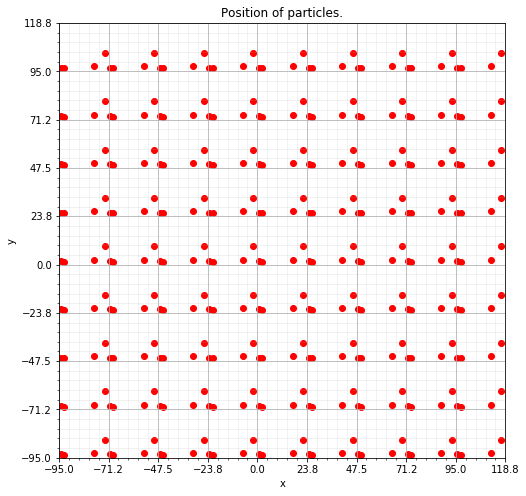

For index 33 Predicted -65275772.0 was 1.9603575167160001


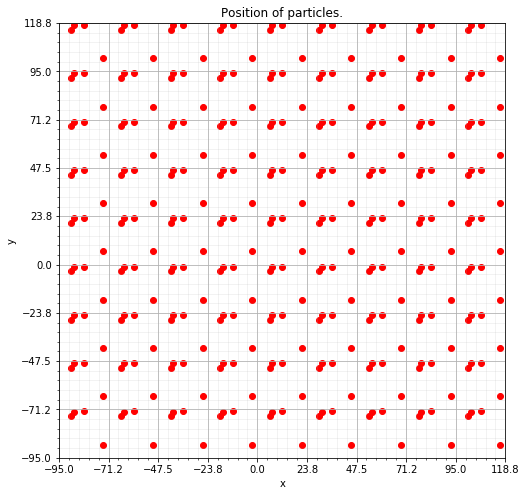

For index 55 Predicted -7133598.5 was 1.960279331616


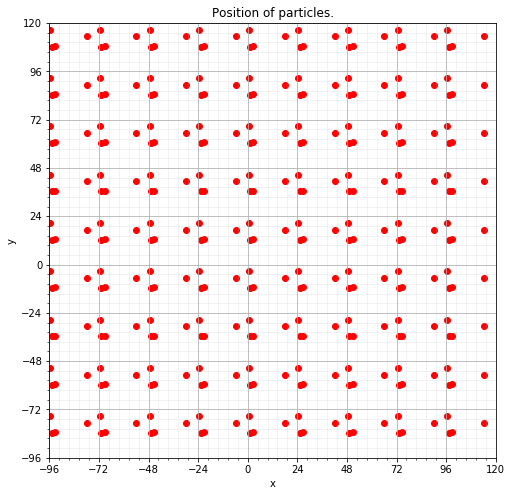

For index 80 Predicted -77616216.0 was 1.960362907116


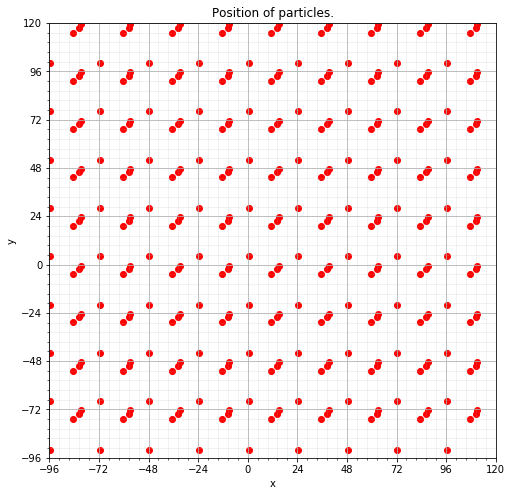

For index 91 Predicted -29919116.0 was 1.960324234116


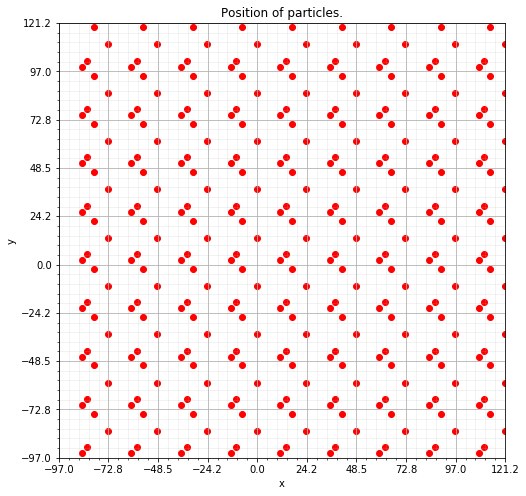

For index 108 Predicted -636558.3 was 1.960354114916



In [27]:
#model = models[3][0]
print(model.evaluate(validationInput[0], validationInput[1]))

y = [[],[]]
for i in range(len(x)):
    y[0].append(model.predict([[testData['eigenvalues'][i]]])[0][0])
    y[1].append(testData['potentialEnergy'][i])


fig, ax1 = plt.subplots(figsize=(8, 8))
ax1.plot(list(x), y[0], label='Predicted potential energy')
ax1.plot(list(x), y[1], label='Real potential energy')
ax1.legend()
ax1.set_xlabel('Position of atom')
ax1.set_ylabel('Potential energy')
ax1.set_title('Predicted potential energy and real potential energy for different positions.')
#ax1.set_ylim(-0.75 * offset , 1.5 * max(y[1]))
plt.show()

for i in range(0,10):
    plotAndPredict(model, validationData, validationData.index[i])

"""
print(model.summary())
for layer in model.layers:
    print(layer.get_weights())
#"""
print()

## Model 4: 8192 wide, 1 layer

In [28]:
settings = [['Dense', 8192, 'softplus', False], ['Dense', 1, 'linear', False]]
learningRate = 5*10**-4

model = makeNetwork(inputSize, settings, learningRate)
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 8192)              131072    
_________________________________________________________________
activation_8 (Activation)    (None, 8192)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 8192      
_________________________________________________________________
activation_9 (Activation)    (None, 1)                 0         
Total params: 139,264
Trainable params: 139,264
Non-trainable params: 0
_________________________________________________________________


Train on 22162 samples, validate on 9499 samples
Epoch 1/30
22162/22162 [==============================] - 3s 113us/step - loss: 1401515600048.9543 - val_loss: 216172156219798.6250
Epoch 2/30
22162/22162 [==============================] - 2s 102us/step - loss: 1306573618540.8613 - val_loss: 35242306622415.5000
Epoch 3/30
22162/22162 [==============================] - 2s 107us/step - loss: 1961568277133.5149 - val_loss: 87988915467899.4531
Epoch 4/30
22162/22162 [==============================] - 2s 105us/step - loss: 1182169241181.9424 - val_loss: 134952481512201.9688
Epoch 5/30
22162/22162 [==============================] - 2s 109us/step - loss: 632963153248.8981 - val_loss: 401957588865961.5625
Epoch 6/30
22162/22162 [==============================] - 2s 107us/step - loss: 1988344541123.2188 - val_loss: 119601128746.5999
Epoch 7/30
22162/22162 [==============================] - 3s 115us/step - loss: 1000220785841.8135 - val_loss: 288970761652809.6875
Epoch 8/30
22162/22162 [=========

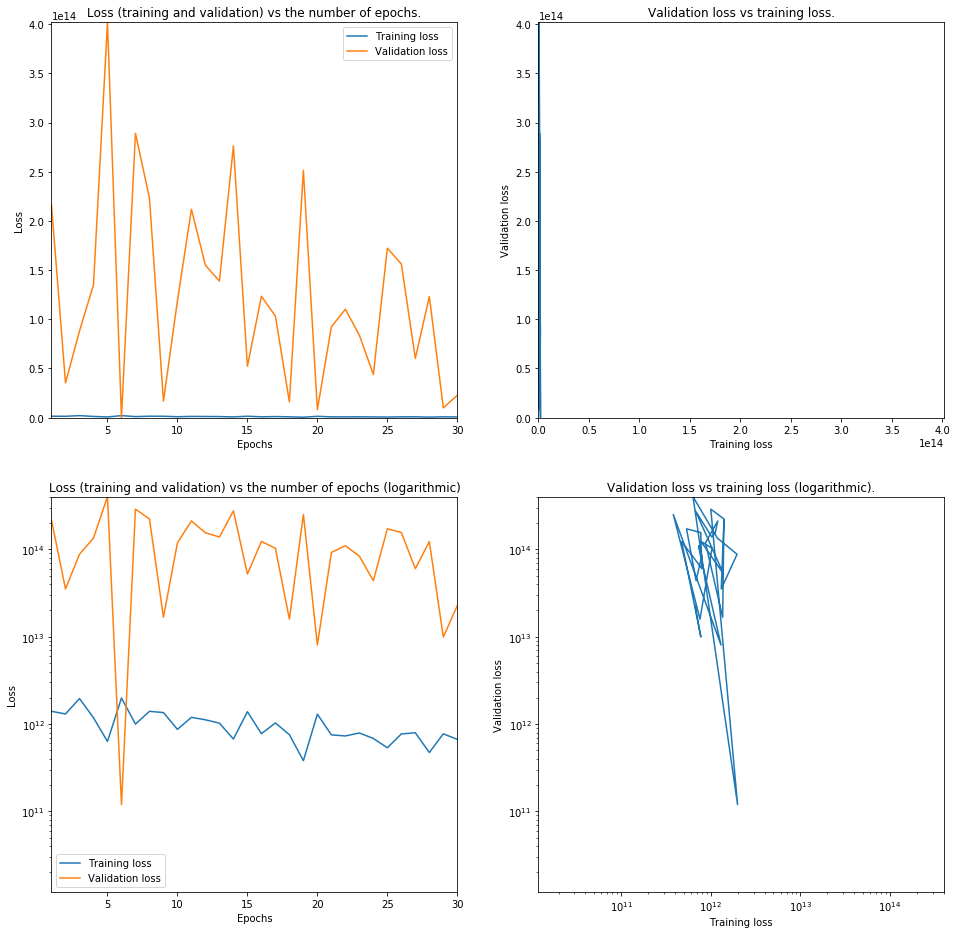

In [29]:
trainNetwork(model, trainingInput, 0.3, numberOfEpochs=30, batchSize=32, verboseSetting=1)
models.append([model, 'model4'])
print()

7915/7915 [==============================] - 0s 37us/step
1075882197091.4781


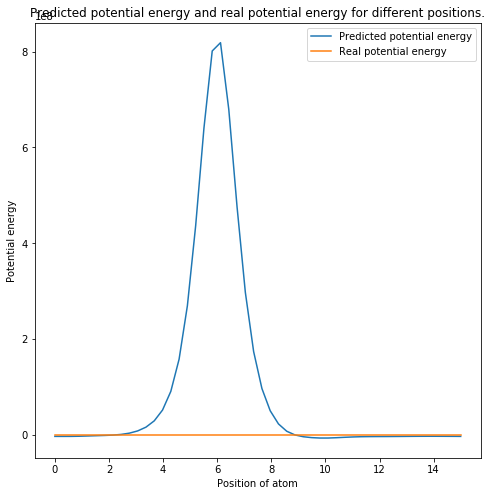

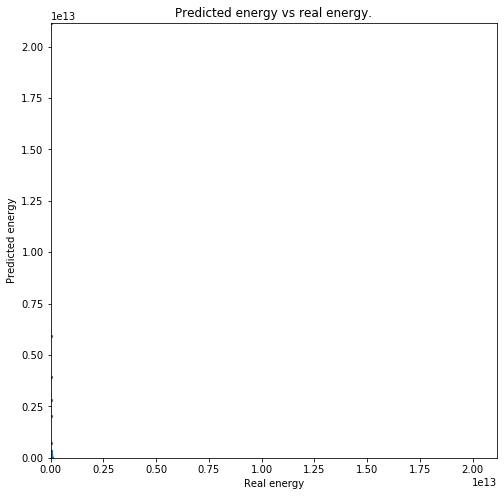

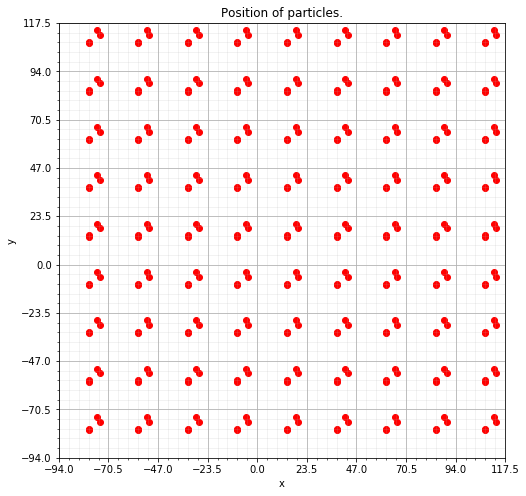

For index 1 Predicted 1206723100.0 was 1.960273923016


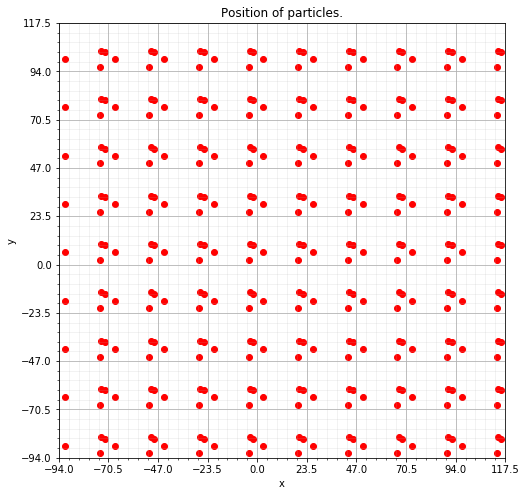

For index 2 Predicted 6339282.5 was 1.960307948516


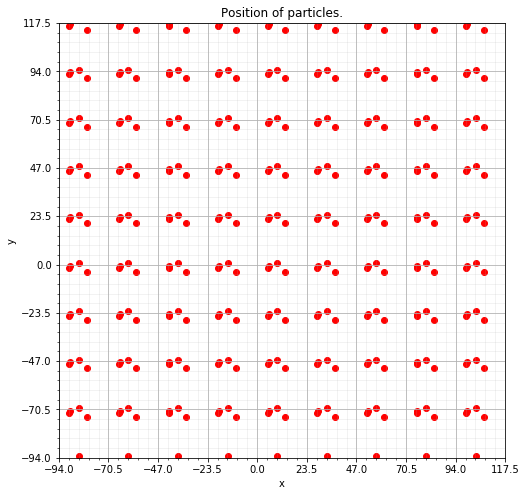

For index 8 Predicted 176459520.0 was 1.959772619816


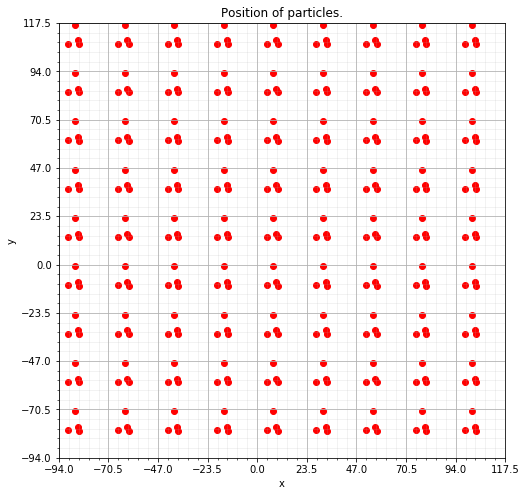

For index 23 Predicted 4798828.0 was 1.959906160916


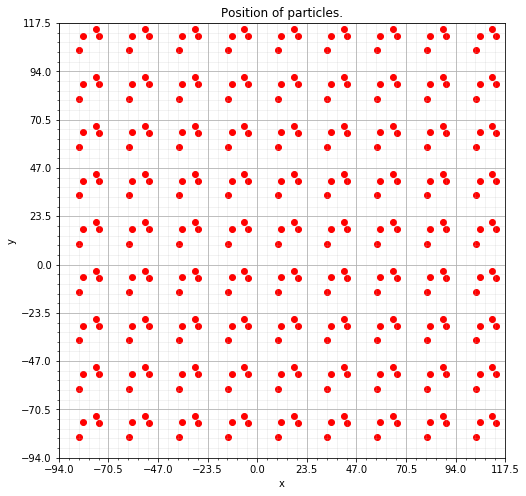

For index 27 Predicted -27725.586 was 1.960369115516


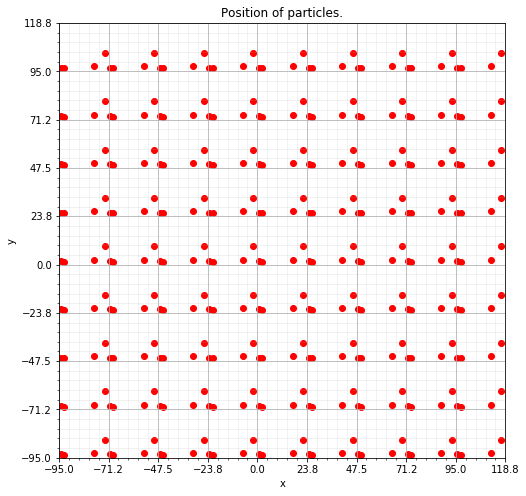

For index 33 Predicted 13141768.0 was 1.9603575167160001


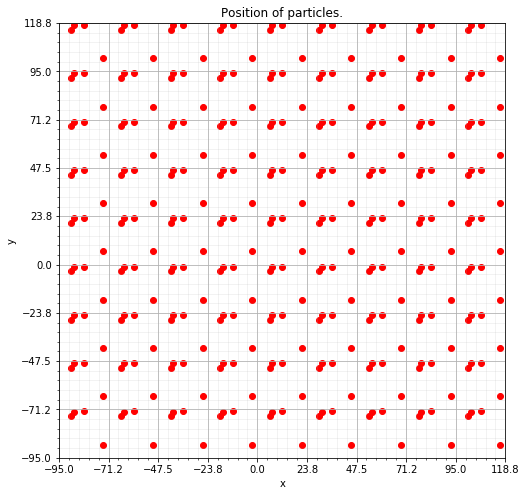

For index 55 Predicted 1047900.0 was 1.960279331616


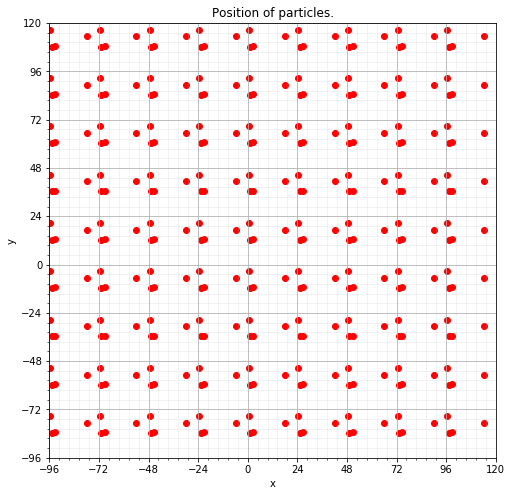

For index 80 Predicted 15811860.0 was 1.960362907116


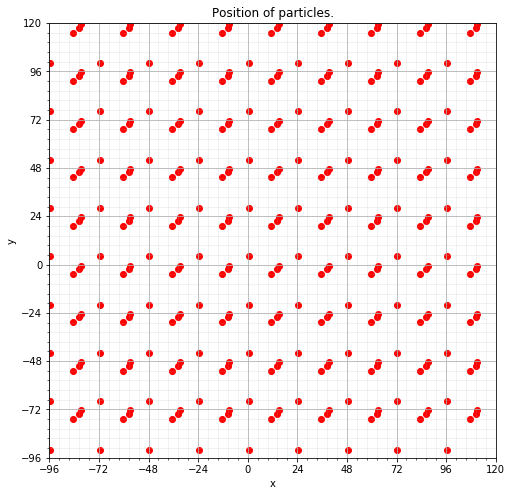

For index 91 Predicted 5565011.5 was 1.960324234116


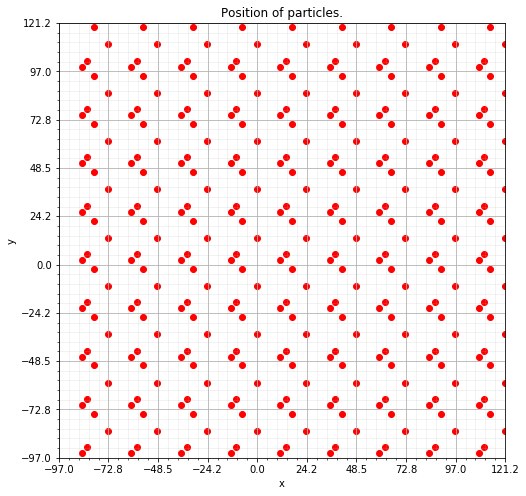

For index 108 Predicted 20177.055 was 1.960354114916



In [30]:
#model = models[4][0]
print(model.evaluate(validationInput[0], validationInput[1]))

y = [[],[]]
for i in range(len(x)):
    y[0].append(model.predict([[testData['eigenvalues'][i]]])[0][0])
    y[1].append(testData['potentialEnergy'][i])


fig, ax1 = plt.subplots(figsize=(8, 8))
ax1.plot(list(x), y[0], label='Predicted potential energy')
ax1.plot(list(x), y[1], label='Real potential energy')
ax1.legend()
ax1.set_xlabel('Position of atom')
ax1.set_ylabel('Potential energy')
ax1.set_title('Predicted potential energy and real potential energy for different positions.')
#ax1.set_ylim(-0.75 * offset , 1.5 * max(y[1]))
plt.show()

makePredictionPlot(model, validationData)

for i in range(0,10):
    plotAndPredict(model, validationData, validationData.index[i])

"""
print(model.summary())
for layer in model.layers:
    print(layer.get_weights())
#"""
print()

## Model 5: 16384 wide, 1 layer

In [31]:
settings = [['Dense', 16384, 'softplus', False], ['Dense', 1, 'linear', False]]
learningRate = 5*10**-4

model = makeNetwork(inputSize, settings, learningRate)
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 16384)             262144    
_________________________________________________________________
activation_10 (Activation)   (None, 16384)             0         
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 16384     
_________________________________________________________________
activation_11 (Activation)   (None, 1)                 0         
Total params: 278,528
Trainable params: 278,528
Non-trainable params: 0
_________________________________________________________________


Train on 22162 samples, validate on 9499 samples
Epoch 1/30
22162/22162 [==============================] - 2s 105us/step - loss: 2005964012917.7424 - val_loss: 59217002034881.0859
Epoch 2/30
22162/22162 [==============================] - 2s 101us/step - loss: 2579755149129.3535 - val_loss: 244049880368622.4375
Epoch 3/30
22162/22162 [==============================] - 2s 101us/step - loss: 2140262812331.5474 - val_loss: 441540658239092.8125
Epoch 4/30
22162/22162 [==============================] - 2s 102us/step - loss: 3345917441617.2139 - val_loss: 564057550170129.5000
Epoch 5/30
22162/22162 [==============================] - 2s 102us/step - loss: 2494141134543.7925 - val_loss: 50740087830565.0156
Epoch 6/30
22162/22162 [==============================] - 2s 101us/step - loss: 1979502940161.8604 - val_loss: 175097794693958.3438
Epoch 7/30
22162/22162 [==============================] - 2s 101us/step - loss: 2163884648879.9192 - val_loss: 358639748501416.2500
Epoch 8/30
22162/22162 [=====

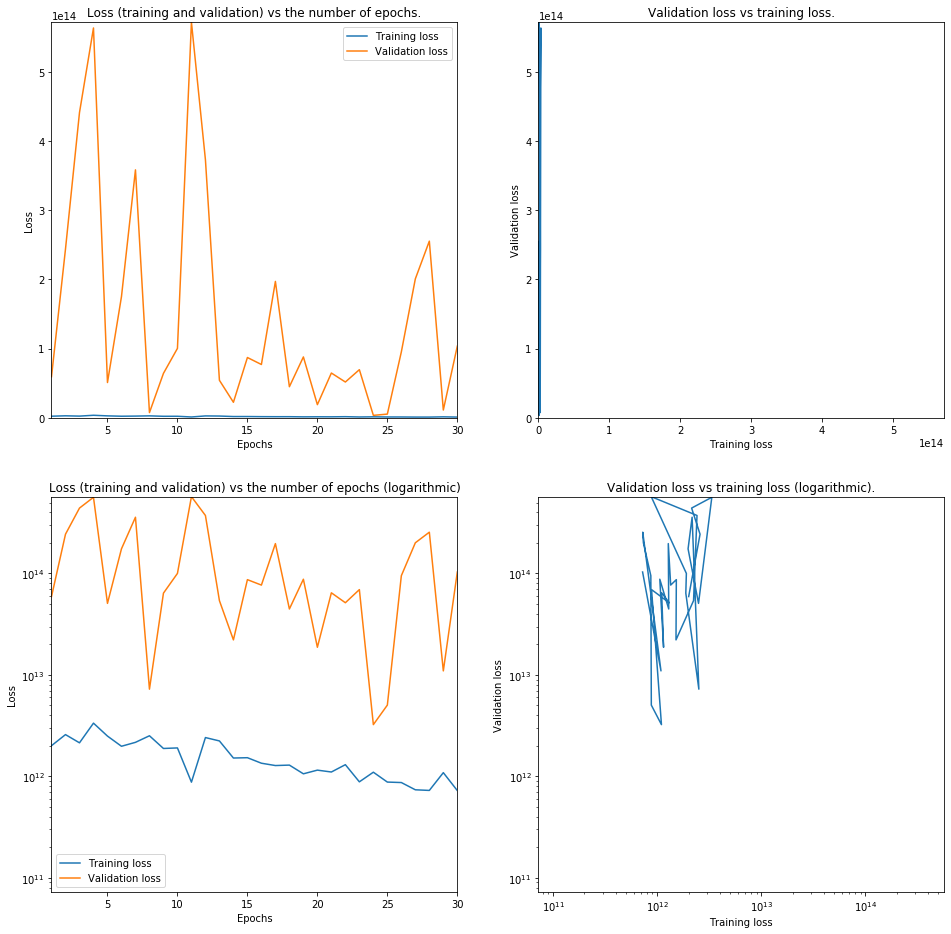

In [32]:
trainNetwork(model, trainingInput, 0.3, numberOfEpochs=30, batchSize=32, verboseSetting=1)
models.append([model, 'model5'])
print()

7915/7915 [==============================] - 0s 40us/step
4912005325383.304


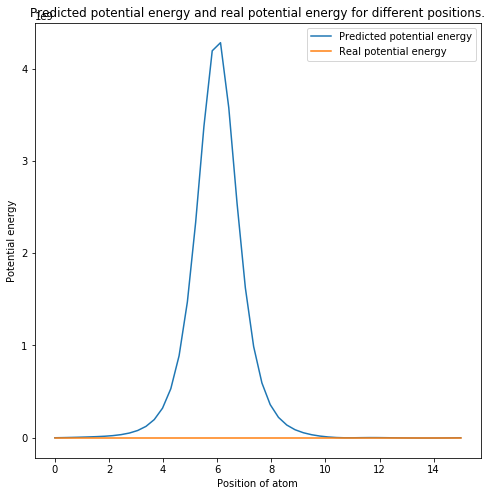

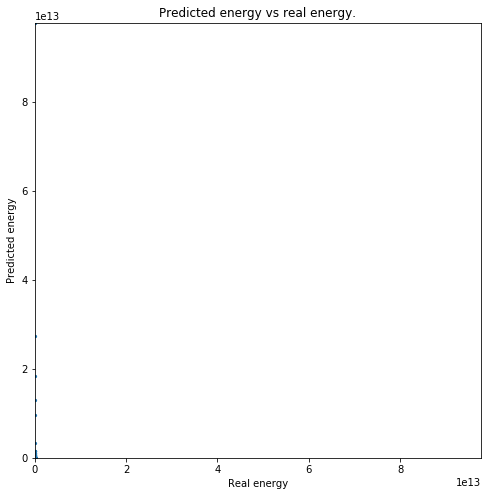

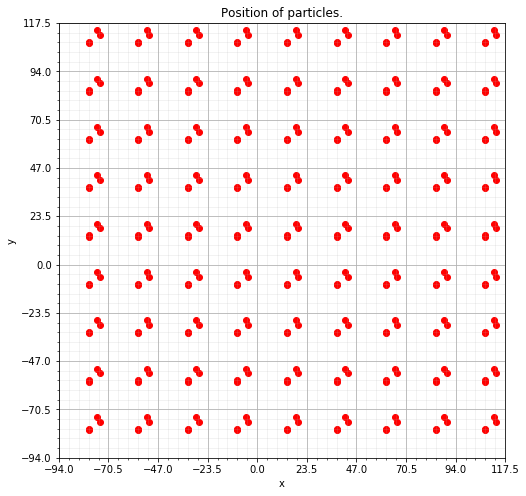

For index 1 Predicted 6296650000.0 was 1.960273923016


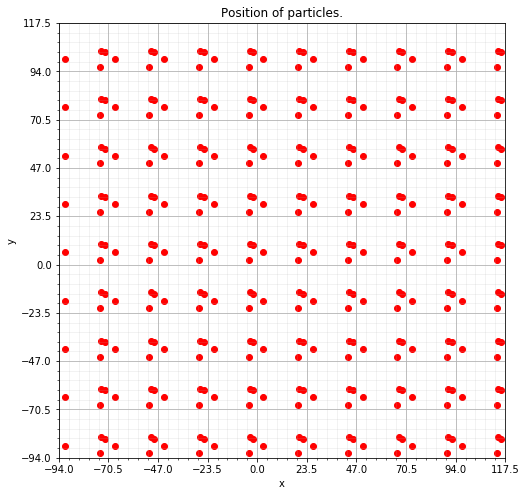

For index 2 Predicted 43631216.0 was 1.960307948516


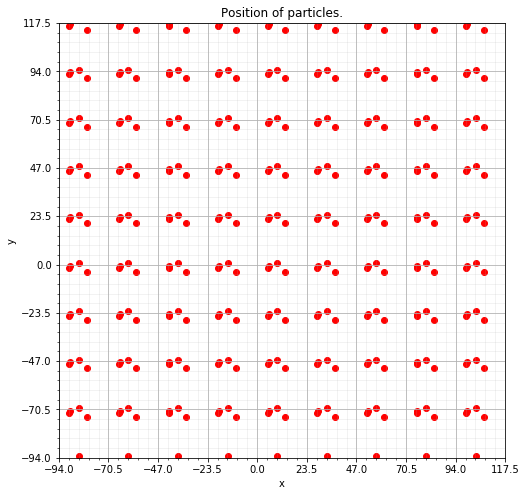

For index 8 Predicted 972589630.0 was 1.959772619816


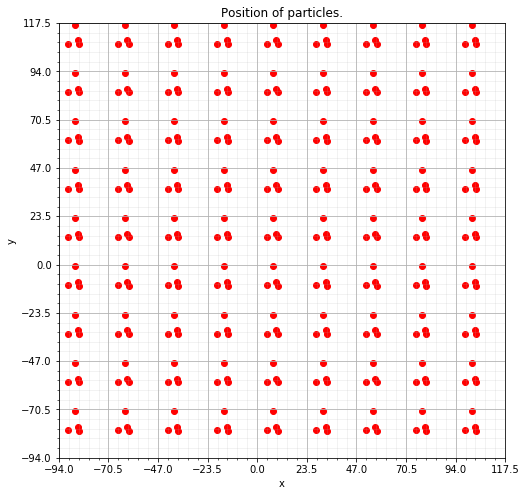

For index 23 Predicted 33910796.0 was 1.959906160916


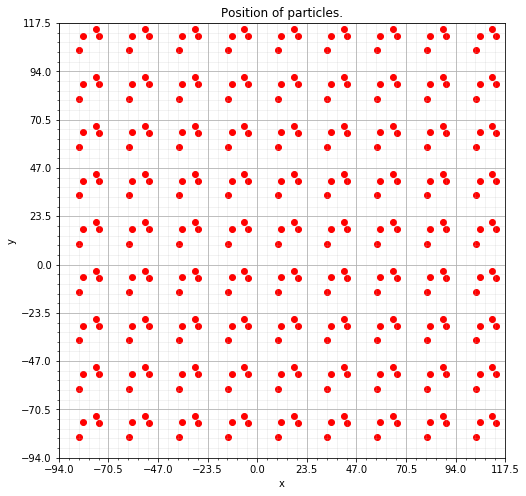

For index 27 Predicted 861874.1 was 1.960369115516


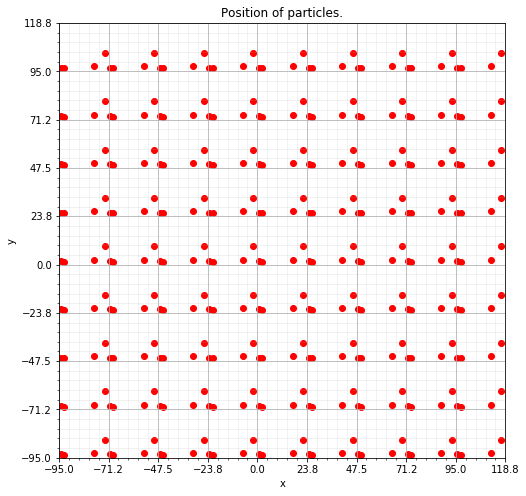

For index 33 Predicted 84455150.0 was 1.9603575167160001


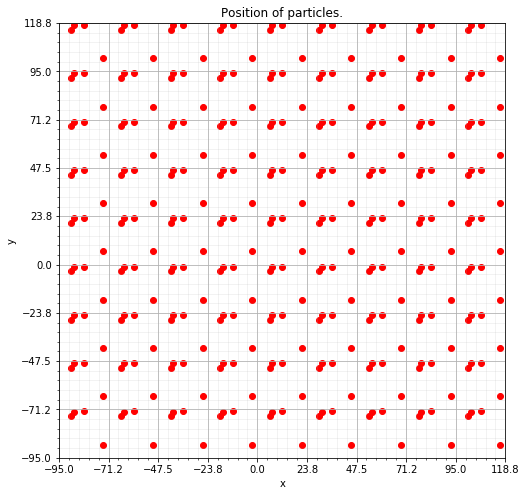

For index 55 Predicted 9152472.0 was 1.960279331616


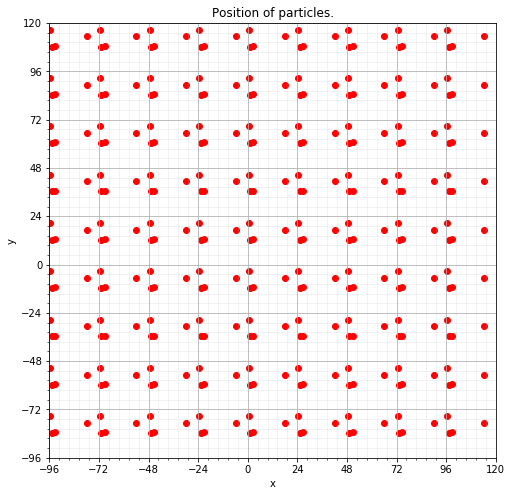

For index 80 Predicted 100333416.0 was 1.960362907116


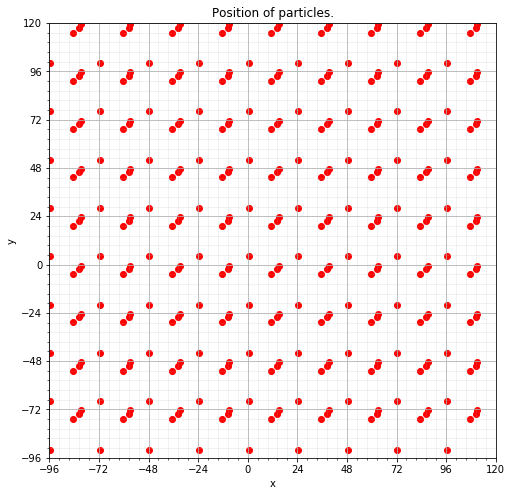

For index 91 Predicted 38687050.0 was 1.960324234116


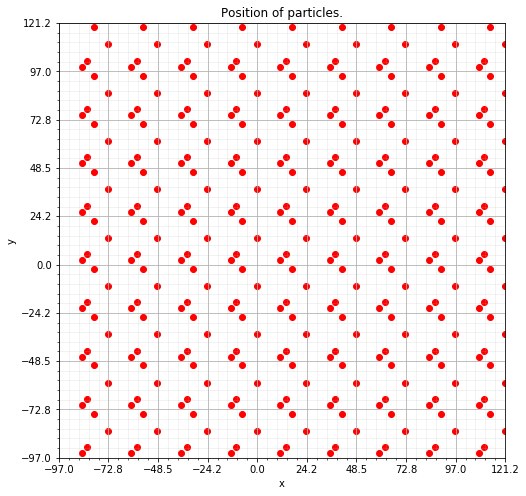

For index 108 Predicted 762062.2 was 1.960354114916



In [33]:
#model = models[5][0]
print(model.evaluate(validationInput[0], validationInput[1]))

y = [[],[]]
for i in range(len(x)):
    y[0].append(model.predict([[testData['eigenvalues'][i]]])[0][0])
    y[1].append(testData['potentialEnergy'][i])


fig, ax1 = plt.subplots(figsize=(8, 8))
ax1.plot(list(x), y[0], label='Predicted potential energy')
ax1.plot(list(x), y[1], label='Real potential energy')
ax1.legend()
ax1.set_xlabel('Position of atom')
ax1.set_ylabel('Potential energy')
ax1.set_title('Predicted potential energy and real potential energy for different positions.')
#ax1.set_ylim(-0.75 * offset , 1.5 * max(y[1]))
plt.show()

makePredictionPlot(model, validationData)

for i in range(0,10):
    plotAndPredict(model, validationData, validationData.index[i])

"""
print(model.summary())
for layer in model.layers:
    print(layer.get_weights())
#"""
print()

## Model 6: 1024 wide, 2 layer

In [34]:
settings = [['Dense', 1024, 'softplus', False], ['Dense', 1024, 'softplus', False], ['Dense', 1, 'linear', False]]
learningRate = 5*10**-4

model = makeNetwork(inputSize, settings, learningRate)
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 1024)              16384     
_________________________________________________________________
activation_12 (Activation)   (None, 1024)              0         
_________________________________________________________________
dense_13 (Dense)             (None, 1024)              1048576   
_________________________________________________________________
activation_13 (Activation)   (None, 1024)              0         
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 1024      
_________________________________________________________________
activation_14 (Activation)   (None, 1)                 0         
Total params: 1,065,984
Trainable params: 1,065,984
Non-trainable params: 0
____________________________________________

Train on 22162 samples, validate on 9499 samples
Epoch 1/30
22162/22162 [==============================] - 3s 134us/step - loss: 863400987878.1580 - val_loss: 4220577473508.1665
Epoch 2/30
22162/22162 [==============================] - 3s 127us/step - loss: 637579858518.4408 - val_loss: 64123869383049.7656
Epoch 3/30
22162/22162 [==============================] - 3s 126us/step - loss: 543036069173.0682 - val_loss: 99424591109979.7188
Epoch 4/30
22162/22162 [==============================] - 3s 126us/step - loss: 469779666401.4280 - val_loss: 35440728946546.3516
Epoch 5/30
22162/22162 [==============================] - 3s 146us/step - loss: 622446211059.6307 - val_loss: 46164197159813.9922
Epoch 6/30
22162/22162 [==============================] - 3s 148us/step - loss: 917708966221.7793 - val_loss: 168937159476247.5938
Epoch 7/30
22162/22162 [==============================] - 3s 134us/step - loss: 1615024823790.9734 - val_loss: 57754475890461.7422
Epoch 8/30
22162/22162 [================

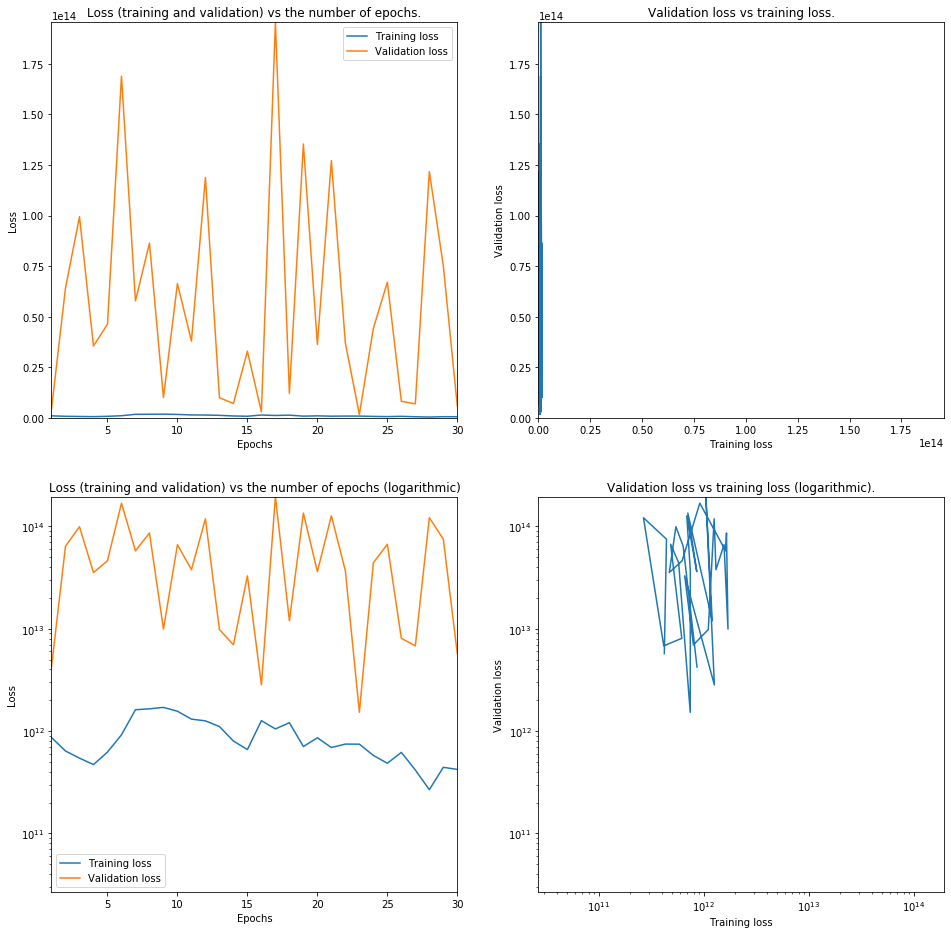

In [35]:
trainNetwork(model, trainingInput, 0.3, numberOfEpochs=30, batchSize=32, verboseSetting=1)
models.append([model, 'model6'])
print()

7915/7915 [==============================] - 0s 39us/step
270606061423.54147


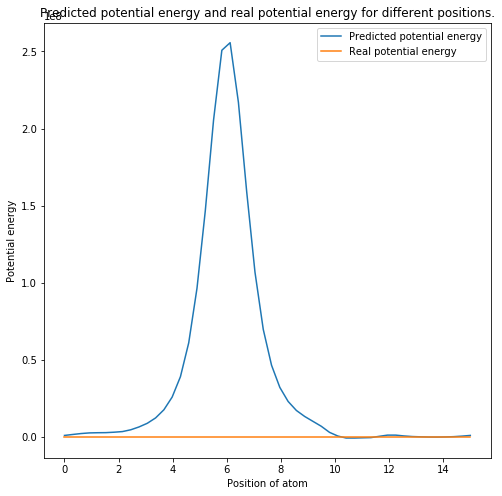

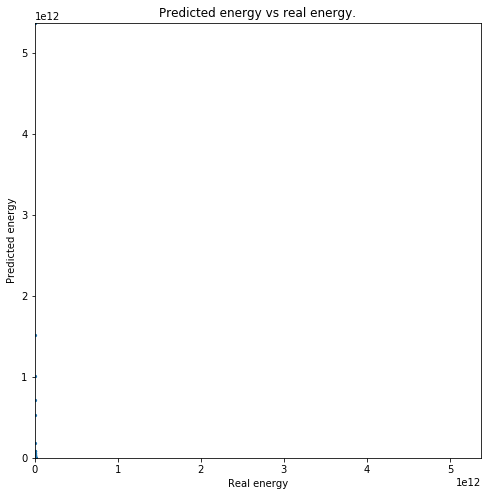

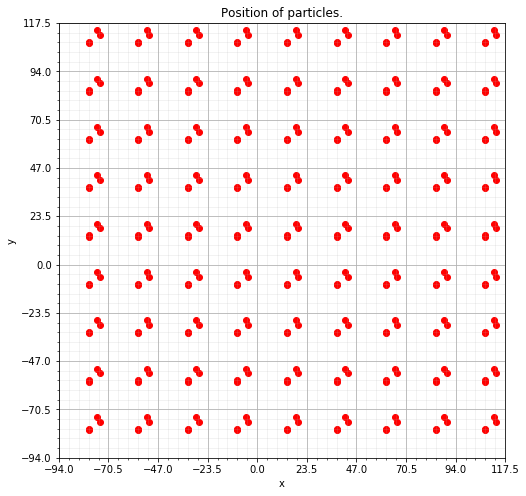

For index 1 Predicted 361671700.0 was 1.960273923016


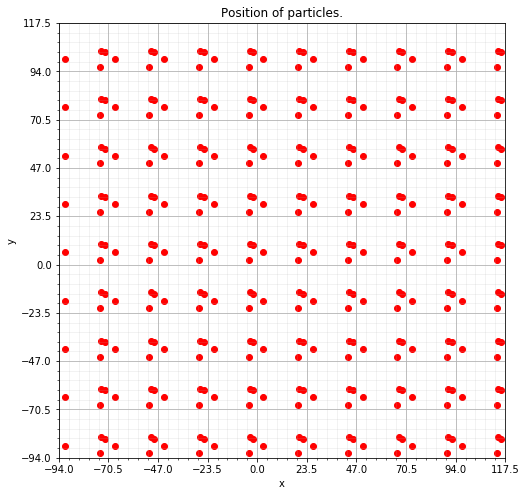

For index 2 Predicted 4722530.0 was 1.960307948516


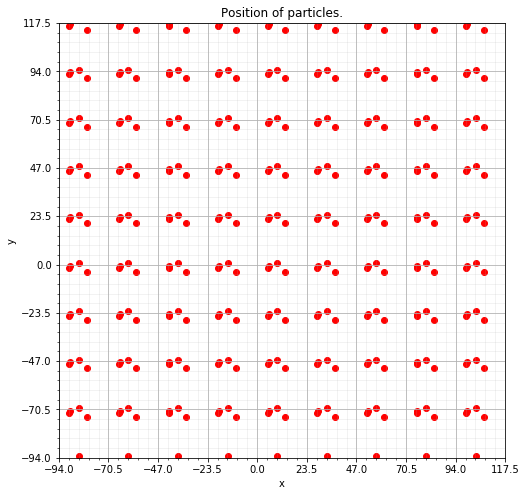

For index 8 Predicted 65801212.0 was 1.959772619816


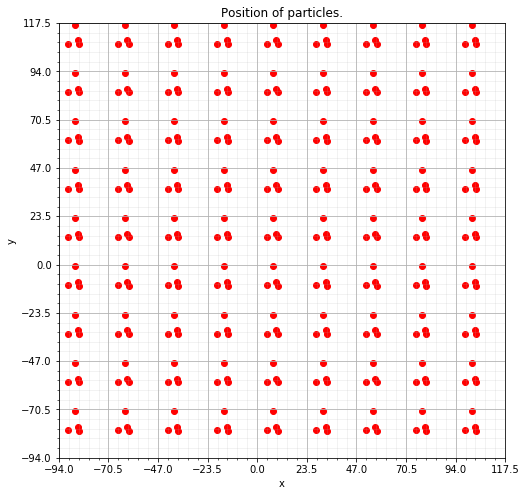

For index 23 Predicted 3809348.2 was 1.959906160916


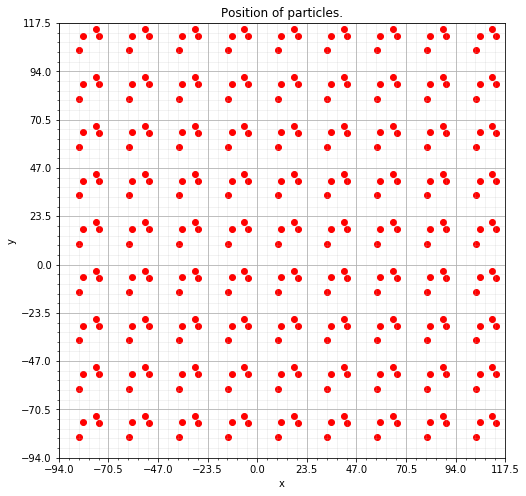

For index 27 Predicted 220758.75 was 1.960369115516


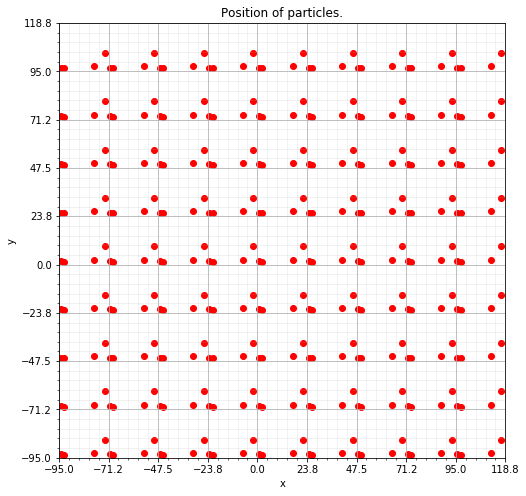

For index 33 Predicted 8185322.5 was 1.9603575167160001


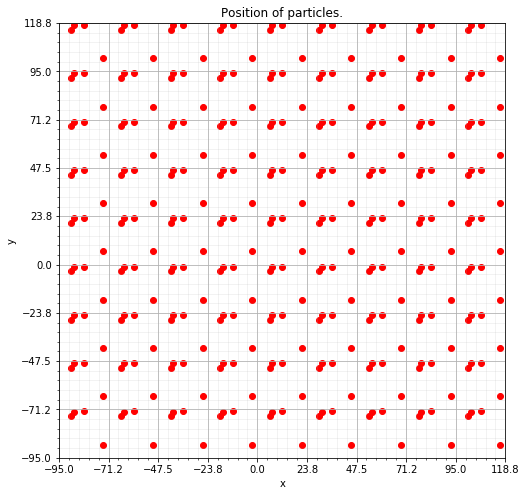

For index 55 Predicted 1252412.2 was 1.960279331616


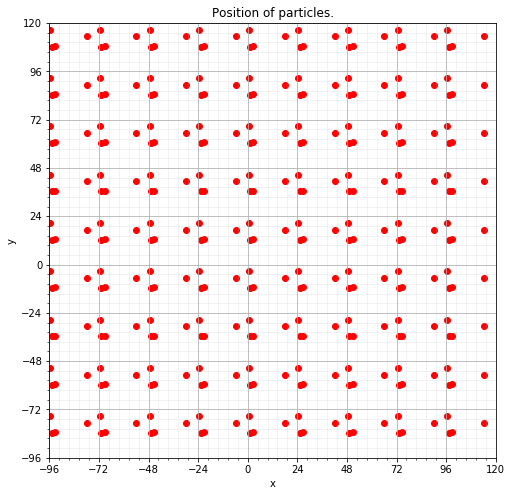

For index 80 Predicted 9439209.0 was 1.960362907116


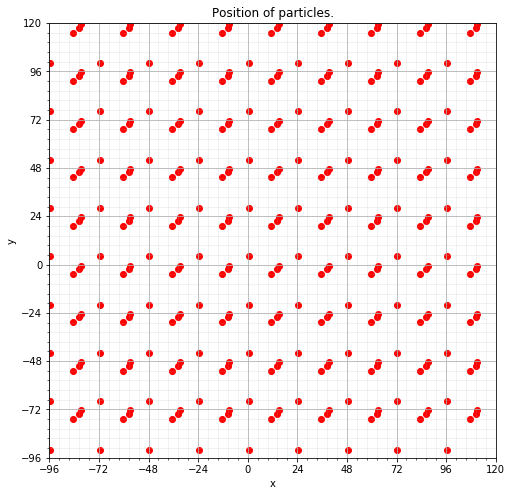

For index 91 Predicted 4254922.0 was 1.960324234116


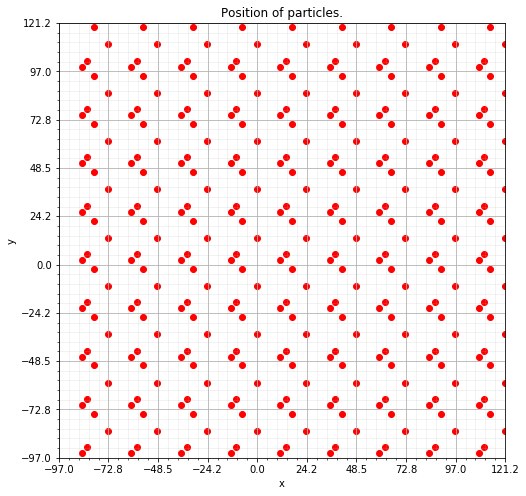

For index 108 Predicted 173200.34 was 1.960354114916



In [36]:
#model = models[6][0]
print(model.evaluate(validationInput[0], validationInput[1]))

y = [[],[]]
for i in range(len(x)):
    y[0].append(model.predict([[testData['eigenvalues'][i]]])[0][0])
    y[1].append(testData['potentialEnergy'][i])


fig, ax1 = plt.subplots(figsize=(8, 8))
ax1.plot(list(x), y[0], label='Predicted potential energy')
ax1.plot(list(x), y[1], label='Real potential energy')
ax1.legend()
ax1.set_xlabel('Position of atom')
ax1.set_ylabel('Potential energy')
ax1.set_title('Predicted potential energy and real potential energy for different positions.')
#ax1.set_ylim(-0.75 * offset , 1.5 * max(y[1]))
plt.show()

makePredictionPlot(model, validationData)

for i in range(0,10):
    plotAndPredict(model, validationData, validationData.index[i])

"""
print(model.summary())
for layer in model.layers:
    print(layer.get_weights())
#"""
print()

## Model 7: 2048 wide, 2 layers

In [37]:
settings = [['Dense', 2048, 'softplus', False], ['Dense', 2048, 'softplus', False], ['Dense', 1, 'linear', False]]
learningRate = 5*10**-4

model = makeNetwork(inputSize, settings, learningRate)
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 2048)              32768     
_________________________________________________________________
activation_15 (Activation)   (None, 2048)              0         
_________________________________________________________________
dense_16 (Dense)             (None, 2048)              4194304   
_________________________________________________________________
activation_16 (Activation)   (None, 2048)              0         
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 2048      
_________________________________________________________________
activation_17 (Activation)   (None, 1)                 0         
Total params: 4,229,120
Trainable params: 4,229,120
Non-trainable params: 0
____________________________________________

Train on 22162 samples, validate on 9499 samples
Epoch 1/30
22162/22162 [==============================] - 11s 517us/step - loss: 815146797570.9943 - val_loss: 50387366003825.6875
Epoch 2/30
22162/22162 [==============================] - 6s 263us/step - loss: 631968608132.3955 - val_loss: 18412017057520.1562
Epoch 3/30
22162/22162 [==============================] - 5s 236us/step - loss: 590660528069.4178 - val_loss: 34062355772848.5781
Epoch 4/30
22162/22162 [==============================] - 5s 232us/step - loss: 822726747317.9840 - val_loss: 130578430802977.1719
Epoch 5/30
22162/22162 [==============================] - 5s 235us/step - loss: 1797433137132.4856 - val_loss: 26254554963681.7031
Epoch 6/30
22162/22162 [==============================] - 5s 240us/step - loss: 1834780686579.9751 - val_loss: 104564035819843.5469
Epoch 7/30
22162/22162 [==============================] - 5s 241us/step - loss: 4070161761099.6660 - val_loss: 75857951538829.7656
Epoch 8/30
22162/22162 [===========

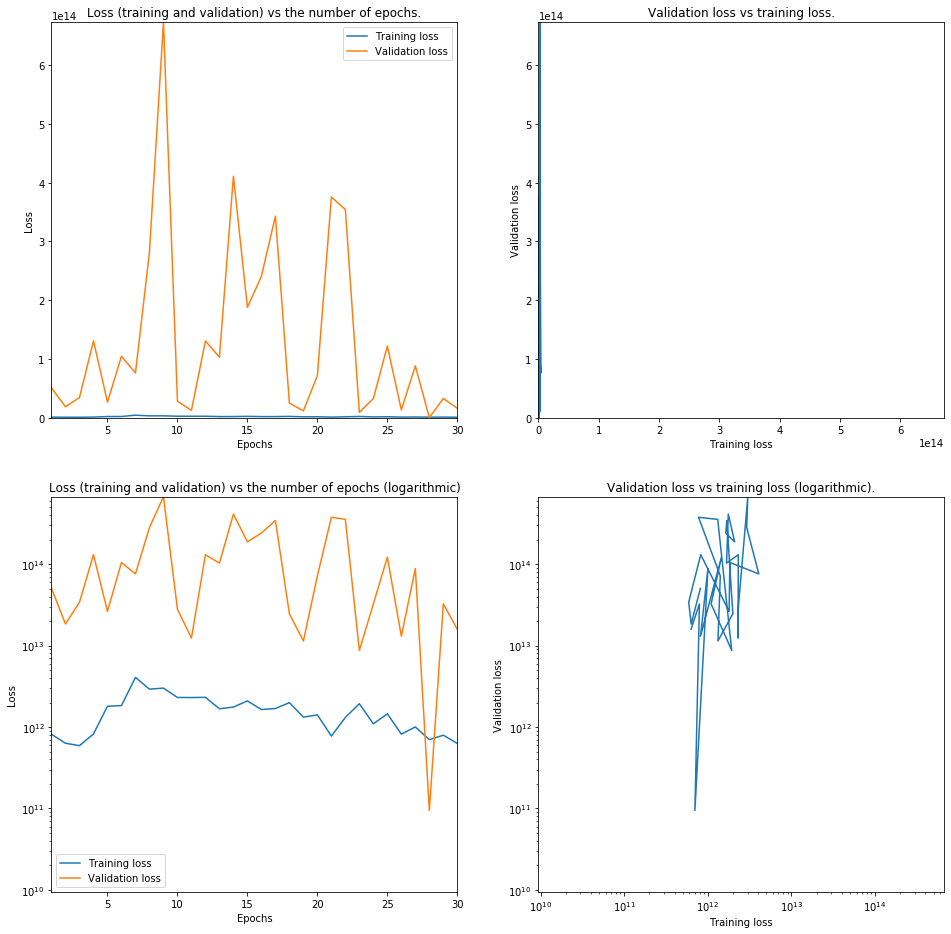

In [38]:
trainNetwork(model, trainingInput, 0.3, numberOfEpochs=30, batchSize=32, verboseSetting=1)
models.append([model, 'model7'])
print()

7915/7915 [==============================] - 0s 44us/step
746466289436.764


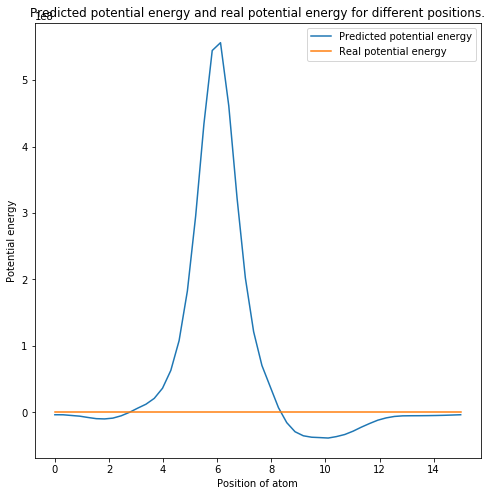

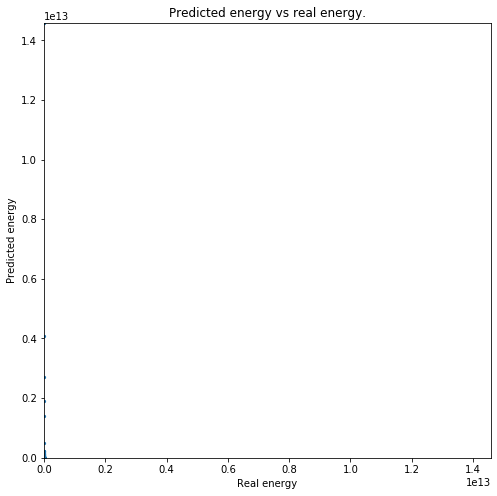

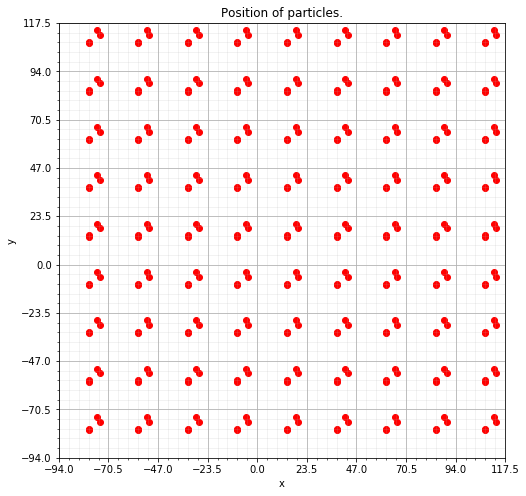

For index 1 Predicted 829971600.0 was 1.960273923016


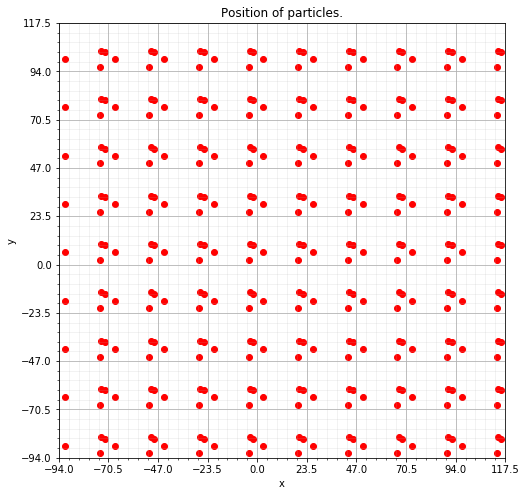

For index 2 Predicted 3112286.0 was 1.960307948516


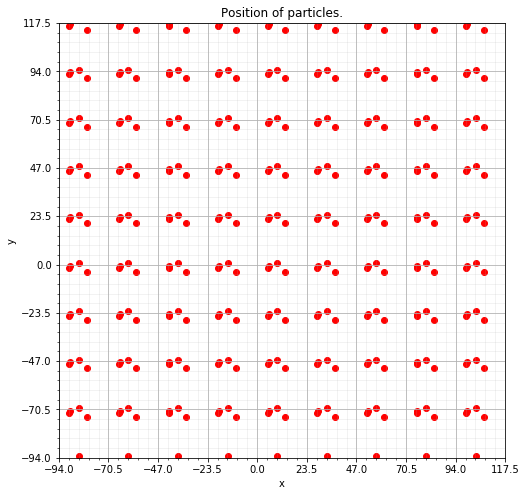

For index 8 Predicted 118396530.0 was 1.959772619816


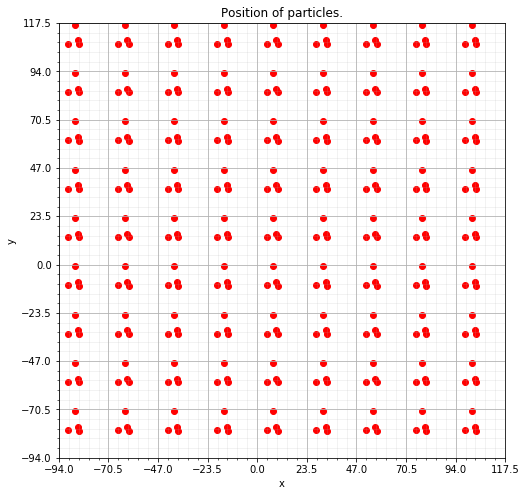

For index 23 Predicted 2174408.0 was 1.959906160916


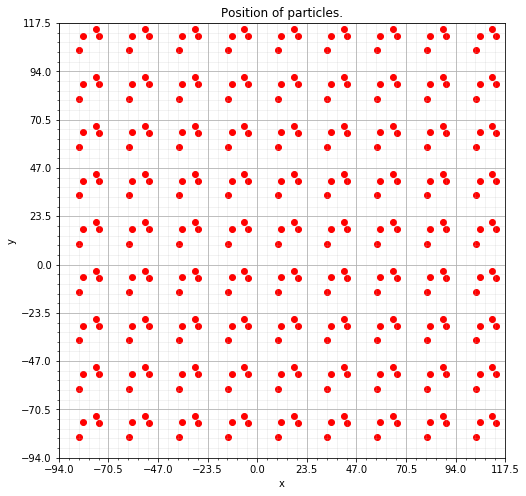

For index 27 Predicted -68792.805 was 1.960369115516


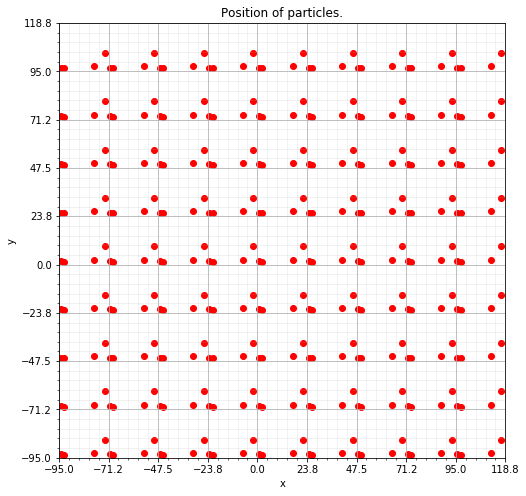

For index 33 Predicted 7142524.5 was 1.9603575167160001


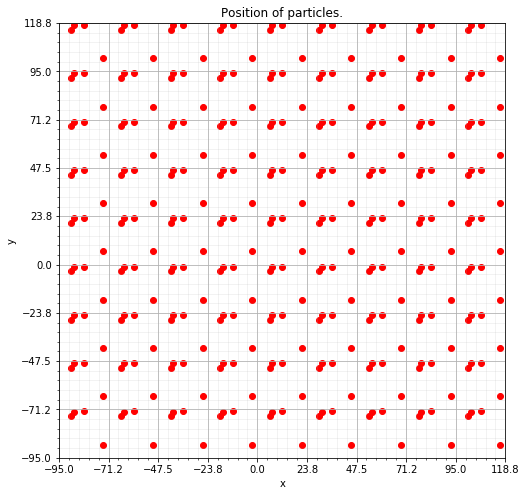

For index 55 Predicted 173224.31 was 1.960279331616


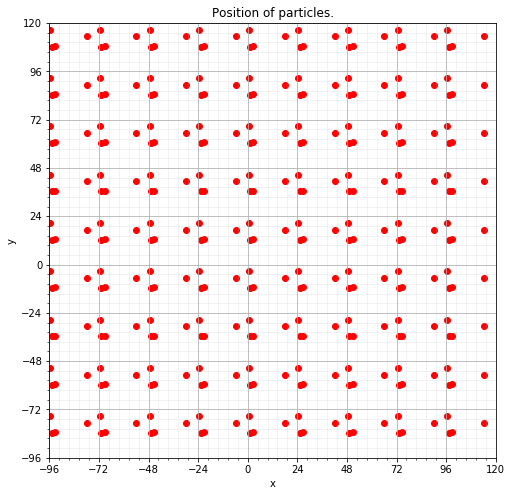

For index 80 Predicted 8924869.0 was 1.960362907116


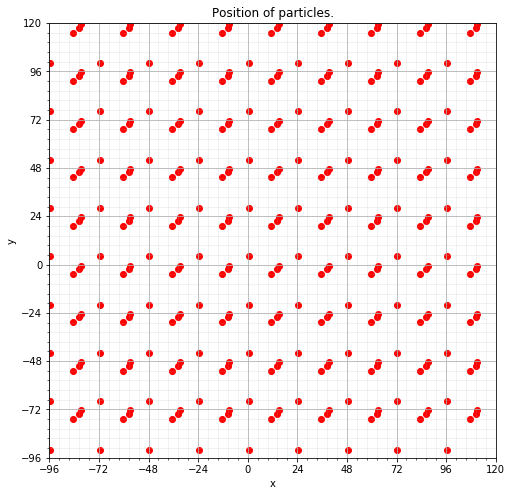

For index 91 Predicted 2601108.0 was 1.960324234116


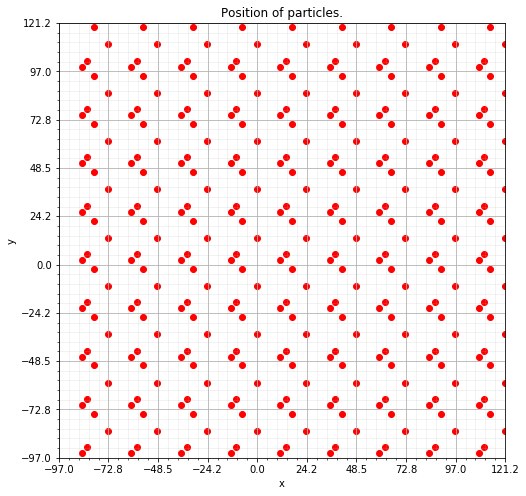

For index 108 Predicted -91073.0 was 1.960354114916



In [39]:
#model = models[7][0]
print(model.evaluate(validationInput[0], validationInput[1]))

y = [[],[]]
for i in range(len(x)):
    y[0].append(model.predict([[testData['eigenvalues'][i]]])[0][0])
    y[1].append(testData['potentialEnergy'][i])


fig, ax1 = plt.subplots(figsize=(8, 8))
ax1.plot(list(x), y[0], label='Predicted potential energy')
ax1.plot(list(x), y[1], label='Real potential energy')
ax1.legend()
ax1.set_xlabel('Position of atom')
ax1.set_ylabel('Potential energy')
ax1.set_title('Predicted potential energy and real potential energy for different positions.')
#ax1.set_ylim(-0.75 * offset , 1.5 * max(y[1]))
plt.show()

makePredictionPlot(model, validationData)

for i in range(0,10):
    plotAndPredict(model, validationData, validationData.index[i])

"""
print(model.summary())
for layer in model.layers:
    print(layer.get_weights())
#"""
print()

## Model 8: 1024 wide, 3 layers

In [40]:
settings = [['Dense', 1024, 'softplus', False], ['Dense', 1024, 'softplus', False], ['Dense', 1024, 'softplus', False], ['Dense', 1, 'linear', False]]
learningRate = 5*10**-4

model = makeNetwork(inputSize, settings, learningRate)
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 1024)              16384     
_________________________________________________________________
activation_18 (Activation)   (None, 1024)              0         
_________________________________________________________________
dense_19 (Dense)             (None, 1024)              1048576   
_________________________________________________________________
activation_19 (Activation)   (None, 1024)              0         
_________________________________________________________________
dense_20 (Dense)             (None, 1024)              1048576   
_________________________________________________________________
activation_20 (Activation)   (None, 1024)              0         
_________________________________________________________________
dense_21 (Dense)             (None, 1)                

Train on 22162 samples, validate on 9499 samples
Epoch 1/30
22162/22162 [==============================] - 4s 186us/step - loss: 696609900548.5375 - val_loss: 175269131218660.5312
Epoch 2/30
22162/22162 [==============================] - 5s 237us/step - loss: 1304677036205.5432 - val_loss: 117498983100190.7188
Epoch 3/30
22162/22162 [==============================] - 4s 198us/step - loss: 1144696083059.3691 - val_loss: 76412350606576.7969
Epoch 4/30
22162/22162 [==============================] - 5s 213us/step - loss: 1066394233993.5458 - val_loss: 222788067893093.7188
Epoch 5/30
22162/22162 [==============================] - 5s 215us/step - loss: 3078072041722.8032 - val_loss: 44002893913610.7344
Epoch 6/30
22162/22162 [==============================] - 4s 172us/step - loss: 2536130562741.3560 - val_loss: 149656035129466.5000
Epoch 7/30
22162/22162 [==============================] - 5s 215us/step - loss: 4043615989862.5859 - val_loss: 984301846117804.5000
Epoch 8/30
22162/22162 [======

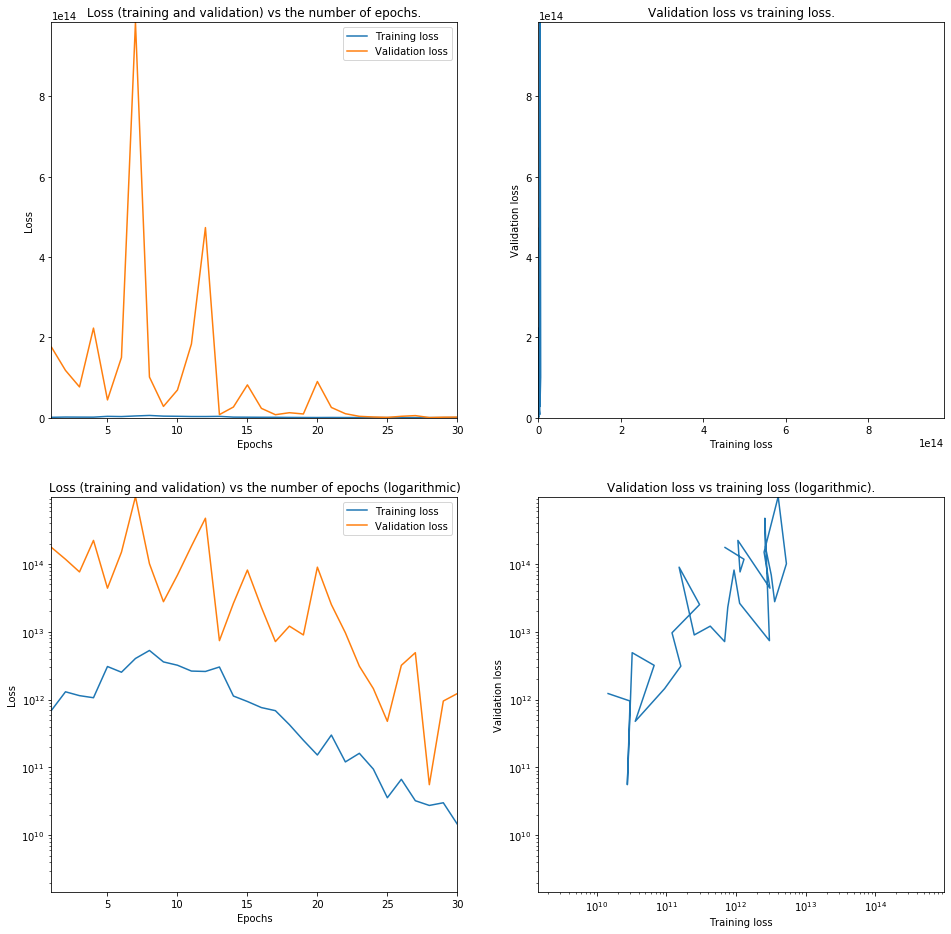

In [41]:
trainNetwork(model, trainingInput, 0.3, numberOfEpochs=30, batchSize=32, verboseSetting=1)
models.append([model, 'model8'])
print()

7915/7915 [==============================] - 0s 52us/step
58655027503.31328


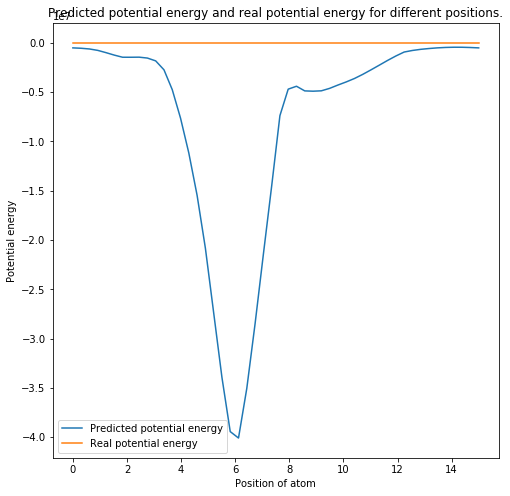

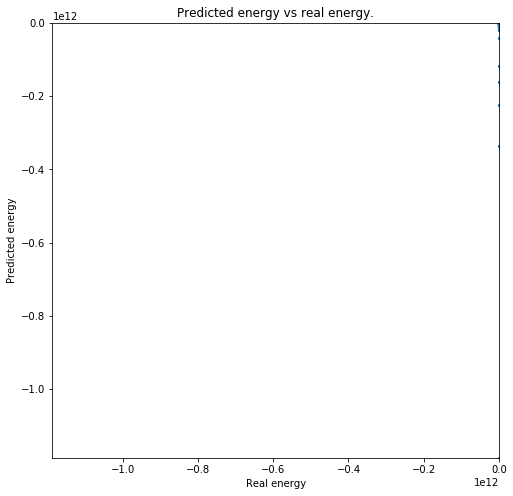

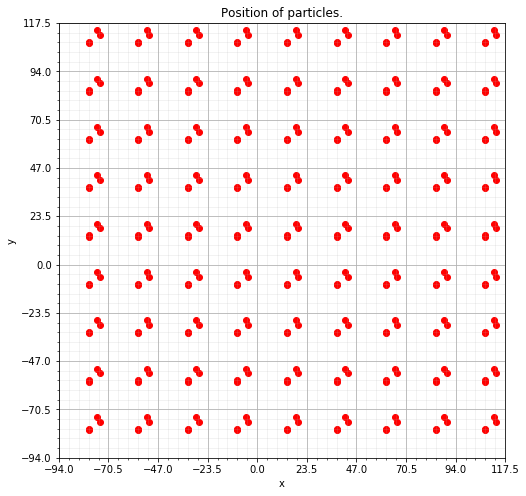

For index 1 Predicted -60108060.0 was 1.960273923016


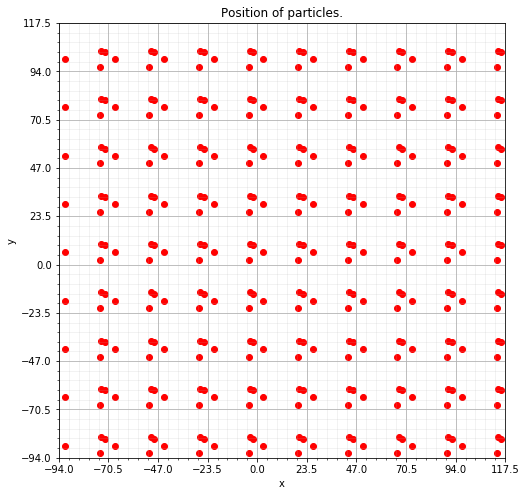

For index 2 Predicted -2625091.5 was 1.960307948516


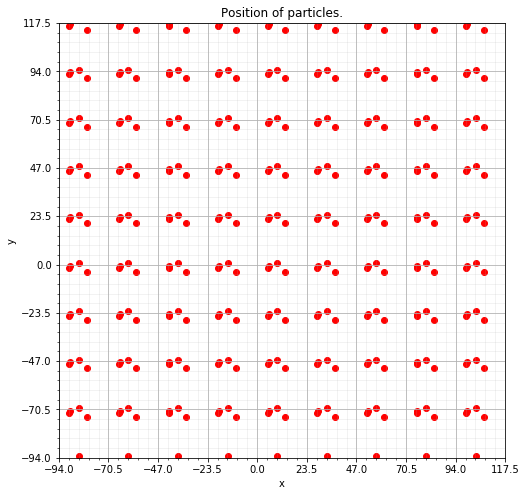

For index 8 Predicted -18229482.0 was 1.959772619816


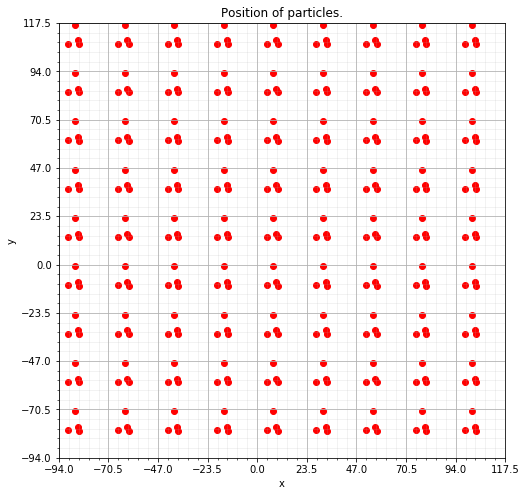

For index 23 Predicted -2191082.5 was 1.959906160916


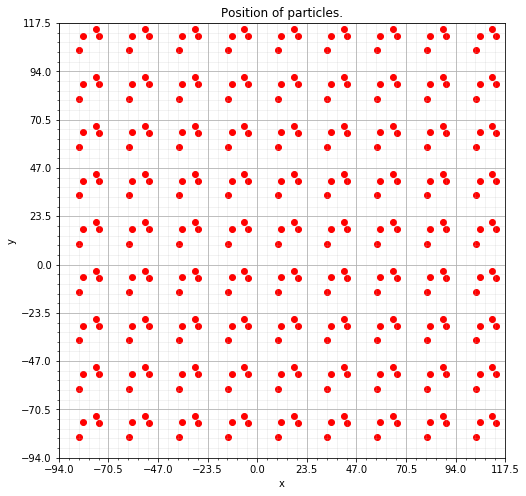

For index 27 Predicted -66852.99 was 1.960369115516


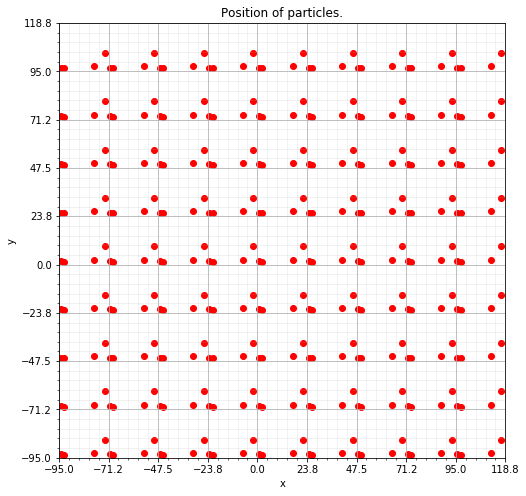

For index 33 Predicted -4282447.0 was 1.9603575167160001


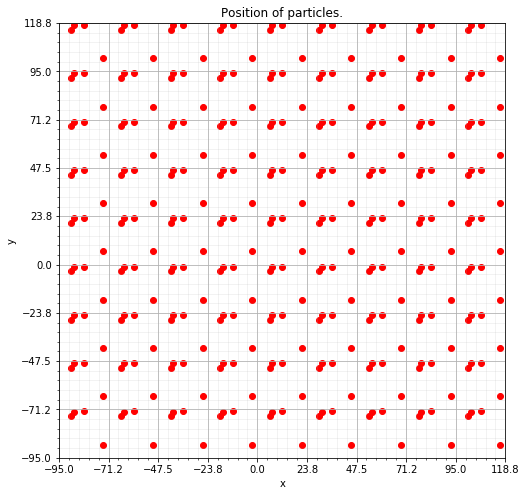

For index 55 Predicted -819925.25 was 1.960279331616


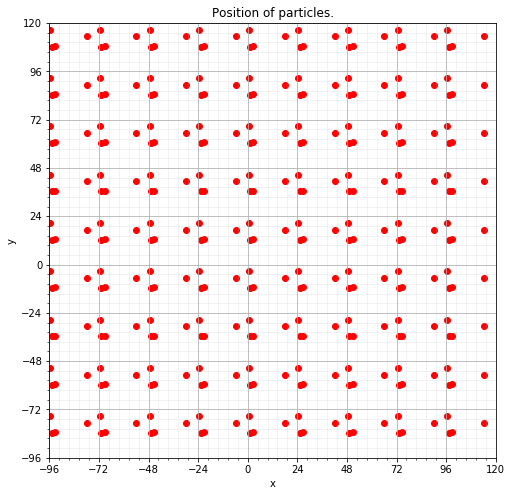

For index 80 Predicted -4817414.5 was 1.960362907116


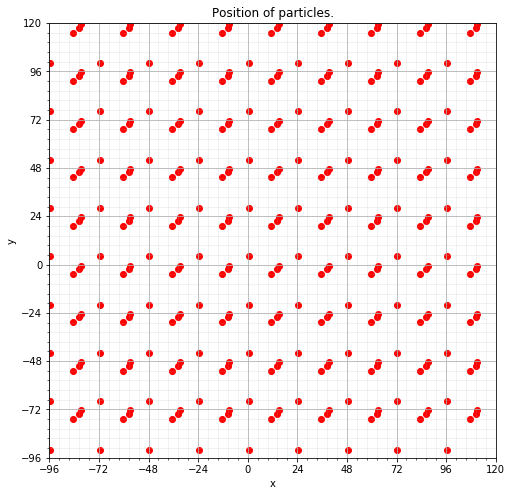

For index 91 Predicted -2428871.2 was 1.960324234116


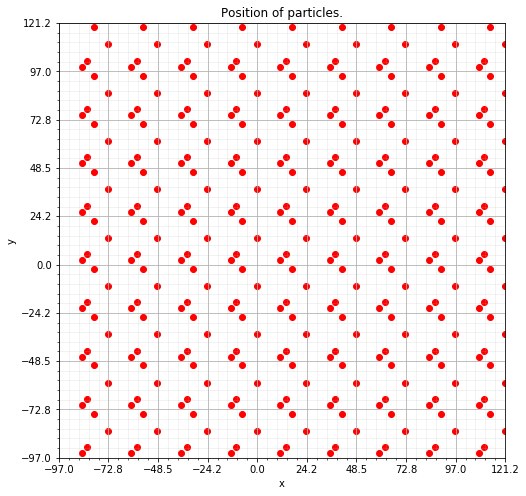

For index 108 Predicted -114534.07 was 1.960354114916



In [42]:
#model = models[8][0]
print(model.evaluate(validationInput[0], validationInput[1]))

y = [[],[]]
for i in range(len(x)):
    y[0].append(model.predict([[testData['eigenvalues'][i]]])[0][0])
    y[1].append(testData['potentialEnergy'][i])


fig, ax1 = plt.subplots(figsize=(8, 8))
ax1.plot(list(x), y[0], label='Predicted potential energy')
ax1.plot(list(x), y[1], label='Real potential energy')
ax1.legend()
ax1.set_xlabel('Position of atom')
ax1.set_ylabel('Potential energy')
ax1.set_title('Predicted potential energy and real potential energy for different positions.')
#ax1.set_ylim(-0.75 * offset , 1.5 * max(y[1]))
plt.show()

makePredictionPlot(model, validationData)

for i in range(0,10):
    plotAndPredict(model, validationData, validationData.index[i])

"""
print(model.summary())
for layer in model.layers:
    print(layer.get_weights())
#"""
print()

## Model 9: 2048 wide, 3 layers

In [43]:
settings = [['Dense', 2048, 'softplus', False], ['Dense', 2048, 'softplus', False], ['Dense', 2048, 'softplus', False], ['Dense', 1, 'linear', False]]
learningRate = 5*10**-4

model = makeNetwork(inputSize, settings, learningRate)
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_22 (Dense)             (None, 2048)              32768     
_________________________________________________________________
activation_22 (Activation)   (None, 2048)              0         
_________________________________________________________________
dense_23 (Dense)             (None, 2048)              4194304   
_________________________________________________________________
activation_23 (Activation)   (None, 2048)              0         
_________________________________________________________________
dense_24 (Dense)             (None, 2048)              4194304   
_________________________________________________________________
activation_24 (Activation)   (None, 2048)              0         
_________________________________________________________________
dense_25 (Dense)             (None, 1)               

Train on 22162 samples, validate on 9499 samples
Epoch 1/30
22162/22162 [==============================] - 20s 910us/step - loss: 991957011677.8890 - val_loss: 857739930185968.2500
Epoch 2/30
22162/22162 [==============================] - 16s 738us/step - loss: 2983615927672.9507 - val_loss: 1080255783460915.5000
Epoch 3/30
22162/22162 [==============================] - 10s 460us/step - loss: 3814993860595.3008 - val_loss: 1060968347663400.5000
Epoch 4/30
22162/22162 [==============================] - 21s 931us/step - loss: 6563187136497.3301 - val_loss: 441862904443813.4375
Epoch 5/30
22162/22162 [==============================] - 21s 943us/step - loss: 6161596797275.5352 - val_loss: 558234845233248.2500
Epoch 6/30
22162/22162 [==============================] - 9s 399us/step - loss: 4869620131327.8213 - val_loss: 202955323642452.0000
Epoch 7/30
22162/22162 [==============================] - 8s 377us/step - loss: 12160063779410.2402 - val_loss: 68224451907244.5547
Epoch 8/30
22162/2216

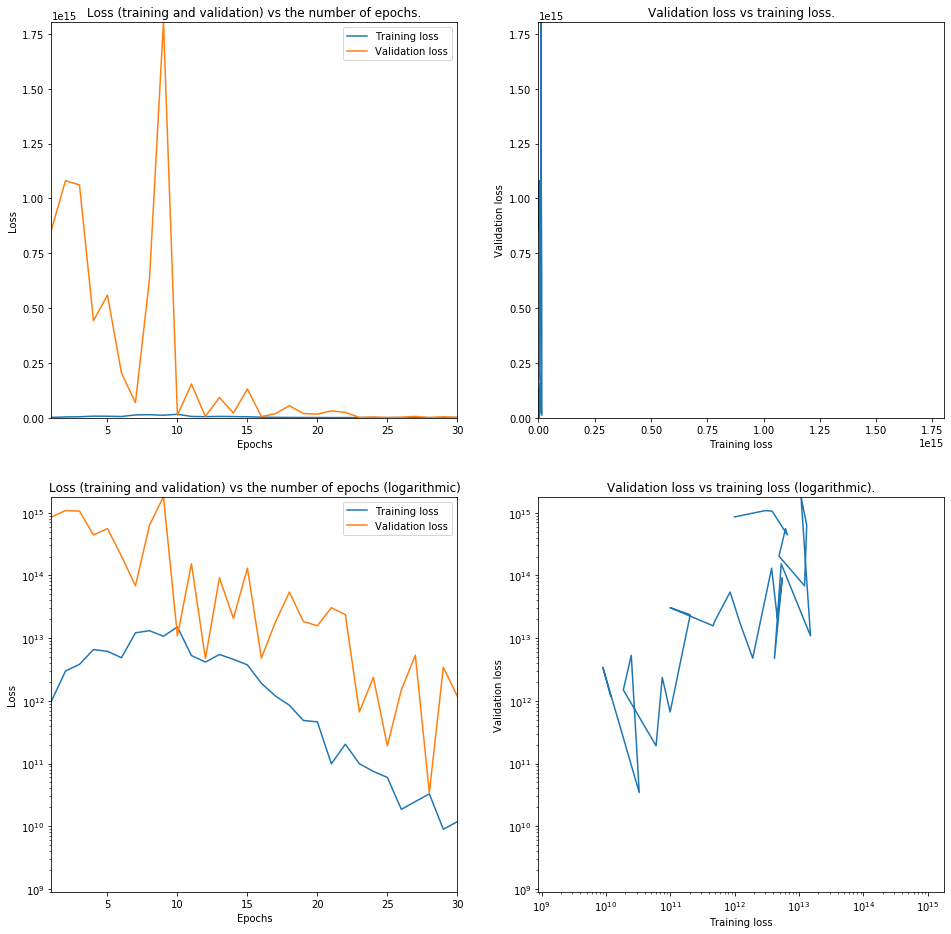

In [44]:
trainNetwork(model, trainingInput, 0.3, numberOfEpochs=30, batchSize=32, verboseSetting=1)
models.append([model, 'model9'])
print()

7915/7915 [==============================] - 0s 47us/step
56823302261.07766


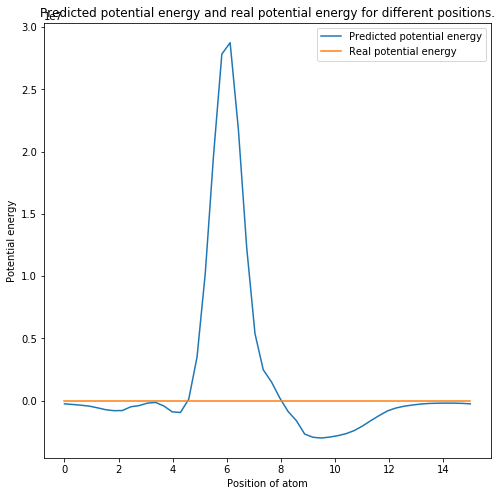

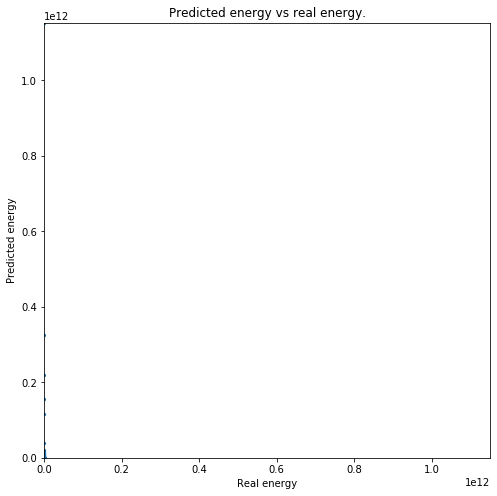

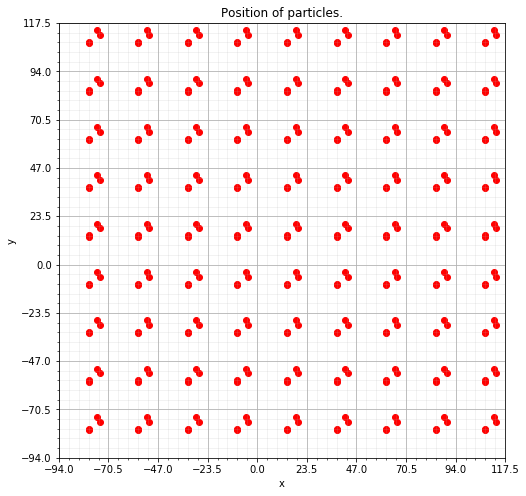

For index 1 Predicted 54529296.0 was 1.960273923016


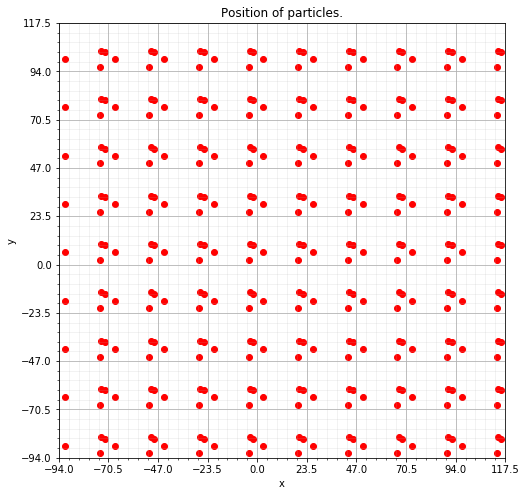

For index 2 Predicted -1659183.5 was 1.960307948516


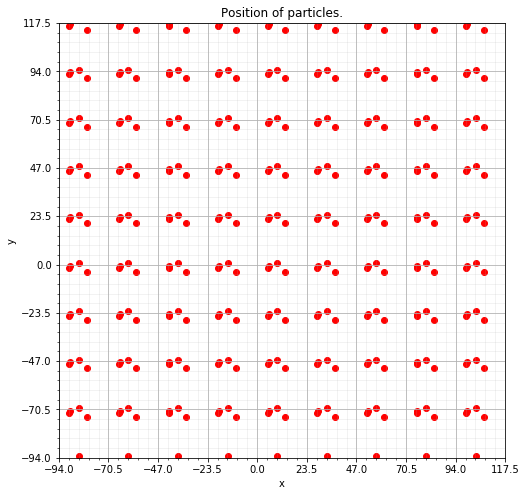

For index 8 Predicted -1147220.0 was 1.959772619816


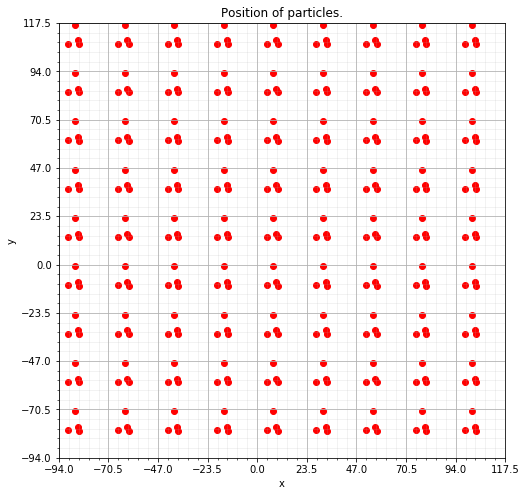

For index 23 Predicted -1472583.6 was 1.959906160916


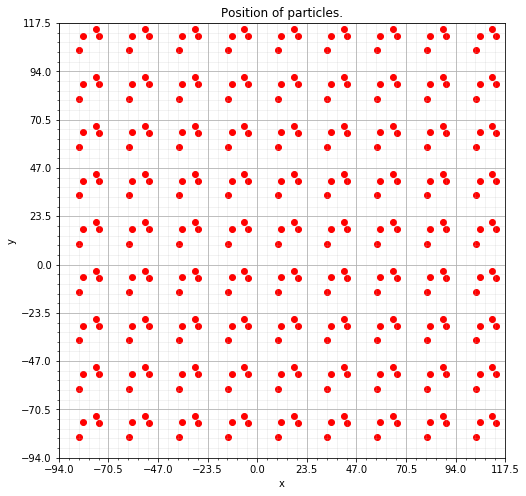

For index 27 Predicted -36606.61 was 1.960369115516


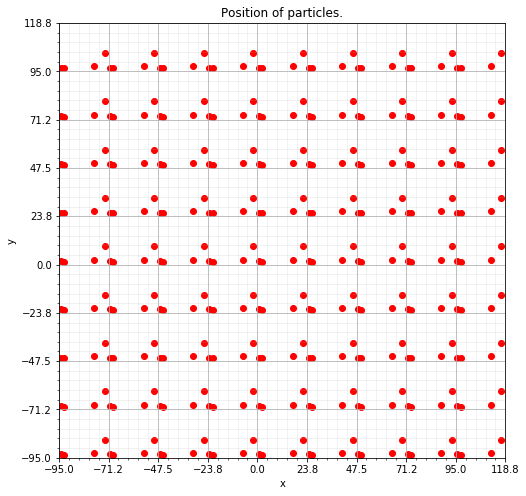

For index 33 Predicted -2338895.5 was 1.9603575167160001


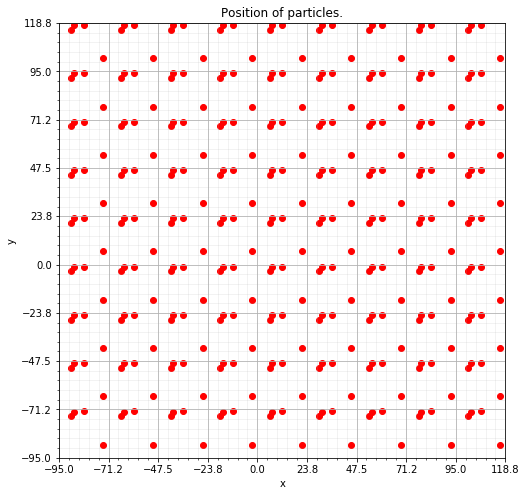

For index 55 Predicted -683160.7 was 1.960279331616


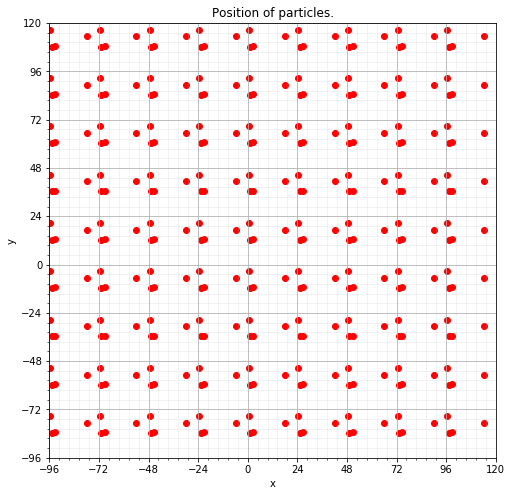

For index 80 Predicted -2446427.0 was 1.960362907116


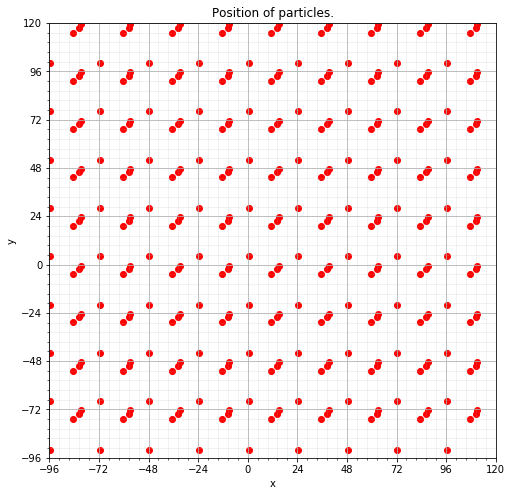

For index 91 Predicted -1599736.5 was 1.960324234116


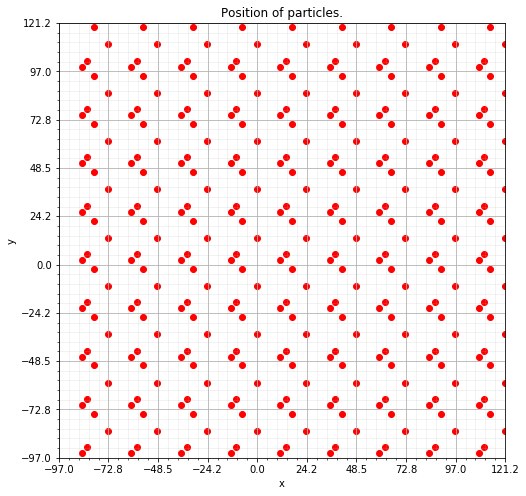

For index 108 Predicted -101843.99 was 1.960354114916



In [45]:
#model = models[9[0]
print(model.evaluate(validationInput[0], validationInput[1]))

y = [[],[]]
for i in range(len(x)):
    y[0].append(model.predict([[testData['eigenvalues'][i]]])[0][0])
    y[1].append(testData['potentialEnergy'][i])


fig, ax1 = plt.subplots(figsize=(8, 8))
ax1.plot(list(x), y[0], label='Predicted potential energy')
ax1.plot(list(x), y[1], label='Real potential energy')
ax1.legend()
ax1.set_xlabel('Position of atom')
ax1.set_ylabel('Potential energy')
ax1.set_title('Predicted potential energy and real potential energy for different positions.')
#ax1.set_ylim(-0.75 * offset , 1.5 * max(y[1]))
plt.show()

makePredictionPlot(model, validationData)

for i in range(0,10):
    plotAndPredict(model, validationData, validationData.index[i])

"""
print(model.summary())
for layer in model.layers:
    print(layer.get_weights())
#"""
print()

## Model 10: 1024 wide, 4 layers

In [46]:
settings = [['Dense', 1024, 'softplus', False], ['Dense', 1024, 'softplus', False], ['Dense', 1024, 'softplus', False], ['Dense', 1024, 'softplus', False], ['Dense', 1, 'linear', False]]
learningRate = 5*10**-4

model = makeNetwork(inputSize, settings, learningRate)
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_26 (Dense)             (None, 1024)              16384     
_________________________________________________________________
activation_26 (Activation)   (None, 1024)              0         
_________________________________________________________________
dense_27 (Dense)             (None, 1024)              1048576   
_________________________________________________________________
activation_27 (Activation)   (None, 1024)              0         
_________________________________________________________________
dense_28 (Dense)             (None, 1024)              1048576   
_________________________________________________________________
activation_28 (Activation)   (None, 1024)              0         
_________________________________________________________________
dense_29 (Dense)             (None, 1024)            

In [47]:
trainNetwork(model, trainingInput, 0.3, numberOfEpochs=30, batchSize=32, verboseSetting=1)
models.append([model, 'model10'])
print()

Train on 22162 samples, validate on 9499 samples
Epoch 1/30
22162/22162 [==============================] - 5s 223us/step - loss: 331204016799.8498 - val_loss: 9080482353216.6914
Epoch 2/30
22162/22162 [==============================] - 8s 377us/step - loss: 14018490084.1199 - val_loss: 479500.3748
Epoch 3/30
22162/22162 [==============================] - 9s 390us/step - loss: 1522000.6787 - val_loss: 558105.1438
Epoch 4/30
22162/22162 [==============================] - 7s 302us/step - loss: 329680.3757 - val_loss: 28106.8907
Epoch 5/30
22162/22162 [==============================] - 6s 268us/step - loss: 2937.1299 - val_loss: 17796.3922
Epoch 6/30
22162/22162 [==============================] - 11s 476us/step - loss: 27230.7372 - val_loss: 3102.0419
Epoch 7/30
22162/22162 [==============================] - 10s 452us/step - loss: 2385.7508 - val_loss: 79.3605
Epoch 8/30
22162/22162 [==============================] - 10s 447us/step - loss: 37.0503 - val_loss: 38.6576
Epoch 9/30
22162/22162

KeyboardInterrupt: 

In [ ]:
#model = models[10][0]
print(model.evaluate(validationInput[0], validationInput[1]))

y = [[],[]]
for i in range(len(x)):
    y[0].append(model.predict([[testData['eigenvalues'][i]]])[0][0])
    y[1].append(testData['potentialEnergy'][i])


fig, ax1 = plt.subplots(figsize=(8, 8))
ax1.plot(list(x), y[0], label='Predicted potential energy')
ax1.plot(list(x), y[1], label='Real potential energy')
ax1.legend()
ax1.set_xlabel('Position of atom')
ax1.set_ylabel('Potential energy')
ax1.set_title('Predicted potential energy and real potential energy for different positions.')
#ax1.set_ylim(-0.75 * offset , 1.5 * max(y[1]))
plt.show()

makePredictionPlot(model, validationData)

for i in range(0,10):
    plotAndPredict(model, validationData, validationData.index[i])

"""
print(model.summary())
for layer in model.layers:
    print(layer.get_weights())
#"""
print()

## Model 11: 1024 wide, 5 layers

In [ ]:
settings = [['Dense', 1024, 'softplus', False], ['Dense', 1024, 'softplus', False], ['Dense', 1024, 'softplus', False], ['Dense', 1024, 'softplus', False], ['Dense', 1024, 'softplus', False], ['Dense', 1, 'linear', False]]
learningRate = 5*10**-4

model = makeNetwork(inputSize, settings, learningRate)
model.summary()

In [ ]:
trainNetwork(model, trainingInput, 0.3, numberOfEpochs=30, batchSize=32, verboseSetting=1)
models.append([model, 'model11'])
print()

In [ ]:
#model = models[11][0]
print(model.evaluate(validationInput[0], validationInput[1]))

y = [[],[]]
for i in range(len(x)):
    y[0].append(model.predict([[testData['eigenvalues'][i]]])[0][0])
    y[1].append(testData['potentialEnergy'][i])


fig, ax1 = plt.subplots(figsize=(8, 8))
ax1.plot(list(x), y[0], label='Predicted potential energy')
ax1.plot(list(x), y[1], label='Real potential energy')
ax1.legend()
ax1.set_xlabel('Position of atom')
ax1.set_ylabel('Potential energy')
ax1.set_title('Predicted potential energy and real potential energy for different positions.')
#ax1.set_ylim(-0.75 * offset , 1.5 * max(y[1]))
plt.show()

makePredictionPlot(model, validationData)

for i in range(0,10):
    plotAndPredict(model, validationData, validationData.index[i])

"""
print(model.summary())
for layer in model.layers:
    print(layer.get_weights())
#"""
print()

## Saving a model

In [ ]:
for i in range(len(models)):
    model = models[i][0]
    print(models[i][1])
    print(model.summary())
    print(model.evaluate(validationInput[0], validationInput[1], verbose=0))
    print('\n \n')

#model = models[1][0]
#model.save('model1.h5')
#model = load_model('model1.h5')